- Copyright **ConvergenciaX Spa** All Rights Reserved.
- Autor: **Joel Cotrado Vargas** joel.cotrado@gmail.com jcotrado@uc.cl
- Date: 01-07-2023
- SPDX-License-Identifier: Apache-2.0
- Disclamer : Proyecto con propositos de demostración y capacitación, no garantizado para uso en producción. Contacte al autor si necesita un desarrollo de uso profesional.


## **FORECAST DE RENDIMIENTO DE UN PORTAFOLIO DE ACCIONES USANDO SERIES DE TIEMPO**

 - **Entender** Las bases de las series de tiempo
 - **Conocer** y preparar los datos de la serie de tiempo y normalizarlos (desde data en bruto, a limpia y procesada para analisis)
 - **Entender** algunos conceptos de indices basicos y manejo de correlaciones 
 - **Crear**  indices para realizar el analisis y pronostico del portafolio (Equal-Weighted Index)
 - **Realizar** un proceso de entrenamiento basico de la serie de tiempo 
 - **Aplicar** metodologias de modelos ARIMA and SARIMAX para hacer el pronostico usando series de tiempo

NOTA 1: Datos obtenidos desde series de tiempo del Banco Central de Chile
https://si3.bcentral.cl/Bdemovil/BDE/IndicadoresDiarios

NOTA 2 : En este ejemplo se considera el pronostico del indice de un portafolio de acciones chilenas (FALABELLA y SONDA), con 2 unidades de cada una.

NOTA 3 : Las series de tiempo disponibles en las carpetas compartidas, tienen datos desde 2015-01-02 a 2023-08-16

### *Librerias requeridas*

In [25]:
!pip install pandas numpy==1.21.4 seaborn==0.10.1 matplotlib scikit-learn==0.22.1 --user
#!pip install tensorflow
#!pip install pandas  numpy seaborn matplotlib  scikit-learn 
#!pip install tqdm pmdarima 

 


In [26]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Descomposicion estacional de los datos Y[t] = T[t] + S[t] + e[t]
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from os import listdir, getcwd
from os.path import isfile, join, basename

from pmdarima import auto_arima
from tqdm import tqdm

from zipfile import ZipFile
from typing import Awaitable

import glob
import asyncio
import skillsnetwork
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
def warn(*args, **kwargs):
    pass # Suppress warnings generated by your code
warnings.warn = warn
warnings.filterwarnings('ignore')

In [27]:
#Crea la carpeta "Forecasting_Cryptocurrency_Markets" en caso que no exista
#!mkdir Forecasting_Cryptocurrency_Markets
#./PronosticoSerieTiempo-Stocks-Cryptos/Metales


# DEFINICION DE FUNCIONES DE APOYO

### A LECTURA SERIES DE DATOS

In [28]:
#
# FUNCIONES DE LECTURA DE DATOS
#

#
# Lee los datos de acciones desde formato json
#
def getPreciosAcciones(simbolo): 
    path = str("./PronosticoSerieTiempo-Stocks-Cryptos/Acciones/"+ simbolo+".json")
    df = pd.read_csv(path)
    #Date,Open,High,Low,Close,Adj Close,Volume
    df.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], unit='ms') #el ms es por que estan en milisegundos
    df['Closetime'] = pd.to_datetime(df['Closetime'], unit='ms')
    df.index=df.Date
    df.to_csv("./Forecasting_Cryptocurrency_Markets/my_crypto/"+ simbolo+".csv")
    return df

#
# Lee datos de varios archivos, localizandos en la misma carpeta
#
def getDatosSeries(files, strat_time, end_time, tipo_archivo="csv", modo_union="left", col_read=None):
    
    folder = glob.glob(files)  # obtiene varios archivos al mismo tiempo
    
    ##Inicializa dataframe con fechas
    dfm = pd.DataFrame(pd.date_range(start=strat_time, end=end_time, freq="d"), columns=["Date"])

    for f in folder:
        if tipo_archivo == "csv":
            df = pd.read_csv(f, sep=",", header=0, usecols=col_read)
        elif tipo_archivo == "excel":  # combine same columns from different files
            df = pd.read_excel(f)
        df["Date"] = pd.to_datetime(df["Date"])
        dfm = dfm.merge(df, how=modo_union, left_on="Date", right_on="Date")
        nombrecampo=""
        if tipo_archivo == "csv":
             nombrecampo=basename(f).replace(".csv", "")
        elif tipo_archivo == "excel":  # combine same columns from different files
             nombrecampo=basename(f).replace(".xlsx", "")         
        dfm.set_axis([*dfm.columns[:-1],nombrecampo], axis=1, inplace=True)
   
    dfm.set_index("Date", inplace=True)  # Fecha como indice
    dfm = dfm.sort_index()
    
    return dfm

#
# Lee datos de un unico archivo, localizandos en la misma carpeta
#

def getDatosSeriesUnico(files, start_time, end_time, tipo_archivo="csv", modo_union="left", col_read=None):
    
    dfm = pd.DataFrame(pd.date_range(start=start_time, end=end_time, freq="d"), columns=["Date"])
    nombrecampo=""
    
    if tipo_archivo == "csv":
            df = pd.read_csv(files, sep=",", header=0, usecols=col_read)
            #nombrecampo=basename(f).replace(".csv", "")
    elif tipo_archivo == "excel":  # combine same columns from different files
            df = pd.read_excel(files,names=col_read)
            #nombrecampo=basename(f).replace(".xlsx", "")            
            
    df["Date"] = pd.to_datetime(df["Date"])
    #print(df.head(10))
    
    dfm = dfm.merge(df, how=modo_union, left_on="Date", right_on="Date")      
    #dfm["Date"]=df["Date"]

    #dfm.set_axis([*dfm.columns[:-1],nombrecampo], axis=1, inplace=True)
   
    dfm.set_index("Date", inplace=True)  # Fecha como indice
    dfm = dfm.sort_index()
    
    return dfm


### A PROCESAMIENTO DE SERIES DE DATOS Y PRONOSTICOS

In [29]:

#
# FUNCIONES DE APOYO A ACTIVIDADES DEL PROCESAMIENTO DE LA SERIE DE TIEMPO
#



#
# separa el dataframe de datos segun el porcentaje indicado en train_percent (grupo entrenamiento y grupo prueba)
#
def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, :-1]), pd.DataFrame(df.iloc[:train_size, -1])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, :-1]), pd.DataFrame(df.iloc[train_size:, -1])
    return predictor_train, predictor_test, target_train, target_test

#
# descomponer la serie de tiempo
#
def decompose(df, period):
    #descomposicion estacional
    decomposition = seasonal_decompose(df, model="additive", period=period)

    fig, axs = plt.subplots(4, 1, figsize=(18, 18))
    # original time series
    axs[0].plot(decomposition.observed)
    axs[0].set_title("Serie Original", size=15)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    # trend
    axs[1].plot(decomposition.trend)
    axs[1].set_title("Tendencia", size=15)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    # seasonal
    axs[2].plot(decomposition.seasonal)
    axs[2].set_title("Estacionalidad", size=15)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    # residual
    axs[3].plot(decomposition.resid)
    axs[3].set_title("Residual", size=15)
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(7))
    plt.show()

#
# Estacionario - Analisis de estacionariedad de la serie de tiempo
#

def stationary(df):
    ori_df = df  # original time series
    fir_df = df.diff().dropna()  # first difference time series / diferencia el elemento actual - el elemento previo.
    sec_df = df.diff().diff().dropna()  # second difference time series
    stationary_test = None

    fig, axs = plt.subplots(3, 3, figsize=(21, 9))
    for i in range(3):
        if i == 0:
            print("Serie de Tiempo Original")
            stationary_test = adfuller(ori_df)
            axs[i, 0].plot(ori_df)
            axs[i, 0].set_title("Serie de Tiempo Original")
            axs[i, 0].label_outer()
            plot_acf(ori_df, ax=axs[i, 1])
            plot_pacf(ori_df, ax=axs[i, 2])
        elif i == 1:
            print("Diferenciación de primer orden")
            stationary_test = adfuller(fir_df)
            axs[i, 0].plot(fir_df)
            axs[i, 0].set_title("Diferenciación de primer orden")
            axs[i, 0].label_outer()
            plot_acf(fir_df, ax=axs[i, 1])
            plot_pacf(fir_df, ax=axs[i, 2])
        elif i == 2:
            print("Diferenciación de Segundo Orden")
            stationary_test = adfuller(sec_df)
            axs[i, 0].plot(sec_df)
            axs[i, 0].set_title("Diferenciación de Segundo Orden")
            axs[i, 0].label_outer()
            plot_acf(sec_df, ax=axs[i, 1])
            plot_pacf(sec_df, ax=axs[i, 2])

        print("ADF Statistic: %f" %stationary_test[0])
        print("p-value: %f\n" %stationary_test[1])

    # hide x and tick labels
    for ax in axs.flat:
        ax.label_outer()
    plt.show()


    

### A LIMPIAR Y NORMALIZAR LAS SERIES DE DATOS

In [30]:
#
# Busca la primera fecha en el dataframe
#
def find_first_date(df, display=False):
    global start_date, end_date
    i = df.isnull().sum().max()
    #print("find_first_date :  df.isnull().sum().max():",i)
    start_date = df.index[i]
    end_date = df.index[-1]
    if display:
        print("La primera fecha de la serie de tiempo es:[", start_date,"]\nLa ultima fecha de la serie de tiempo es :[", end_date, "]")

#
# Limpiar data
#   (1) se obtienen los datos desde la fecha de inicio en adelante.
#
def clean_data(tv, pv):
    
    df1, df2 = tv.copy(), pv.copy()
    find_first_date(tv, True)
    
    #se hace el corte de los datos segun fecha de inicio
    df1 = df1[start_date:]
    df2 = df2[start_date:]
 
    # Completar la fecha faltante con el valor del dia previo
    df2 = df2.reindex(pd.date_range(start_date, end_date)).reset_index().rename(columns={"index": "Date"})
    df2 = df2.groupby(df2["Date"].dt.time).ffill()
    df2.set_index("Date", inplace=True)
    return df1, df2

def prepare_data(dataset):
    df = dataset.copy()
    
    # normalized the data with min-max scaling
    df_nor = pd.DataFrame(MinMaxScaler().fit_transform(df)).assign(label=df.index)
    df_nor.columns = df.columns.to_list() + ["Date"]
    df_nor.set_index("Date", inplace=True)
    #print("prepare_data->df_nor",df_nor.tail(10))
    
    # Se eliminan las correlaciones debiles(% between -0.2 to 0.2)
    correlaciones = df_nor.corr(method="pearson")
    #print("prepare_data->cor:",cor.tail(20))
    df_nor.drop(df_nor.columns[(correlaciones.Index >= -0.2) & (correlaciones.Index <= 0.2)], axis=1, inplace=True)
    return df_nor , correlaciones


# Crear indice por capital ponderado capitalization-weighted ()

# Capitalization-Weighted Index
#
# fecha de inversion
# volumen invertido
# nombrecrypto
# retorna indice de peso de capitalización

def capitalizationWeighted(investment_date, investment_volume, nemonicos):
    price = my_assets.loc[my_assets.index == investment_date]
    share = pd.DataFrame(columns=nemonicos)
    share.loc[0] = investment_volume
    total_value = sum([price.values * share.values][0][0])

    #weight.index =  my_assets.loc[my_assets.index == investment_date]
    weight = pd.DataFrame(columns=nemonicos)
    weight.loc[0] = [price.values * share.values][0][0] / total_value

    return weight

In [31]:
#
# Parametros globales usados en el notebook
#

# Fechas utilizadas para hacer un analisis mas fino de un periodo de la serie de tiempo
fechabase_filtro_analisis = pd.to_datetime("2022-08-01")
fechafin_filtro_analisis = pd.to_datetime("2023-08-20")

#
# Aqui podemos configurar el rango de fechas de la serie de tiempo sobre la cual trabajaremos, los datos disponibles en el proyecto parten en 2013 y 2015 para las acciones
#
start_time_serie = pd.to_datetime("2017-01-02")
end_time_serie = pd.to_datetime("2023-08-16")

# OBTIENER VALORES DE METALES 

In [32]:
path = str("./PronosticoSerieTiempo-Stocks-Cryptos/Metales/*.xlsx")
metales = getDatosSeries(path, "2015-01-02", "2023-08-16","excel","left", ["Date","Precio"])
metales.dropna(axis='rows',how='all',inplace=True)
path = str('./PronosticoSerieTiempo-Stocks-Cryptos/metales.xlsx')
metales.to_excel(path, index = True)

print(metales.tail(5))
print(metales.head(5))
#print("IsNull")
#print(metales.isnull().sum())
#print("IsNA")
#print(metales.isna().sum())


            CobreUSD   OroUSD
Date                         
2023-08-09      3.83  1925.40
2023-08-10      3.77  1916.01
2023-08-11      3.79  1914.09
2023-08-14      3.79  1913.26
2023-08-16      3.74  1909.17
            CobreUSD   OroUSD
Date                         
2015-01-02      2.89  1206.00
2015-01-05      2.89  1172.00
2015-01-06      2.87  1200.00
2015-01-07      2.82  1210.25
2015-01-08      2.82  1210.50


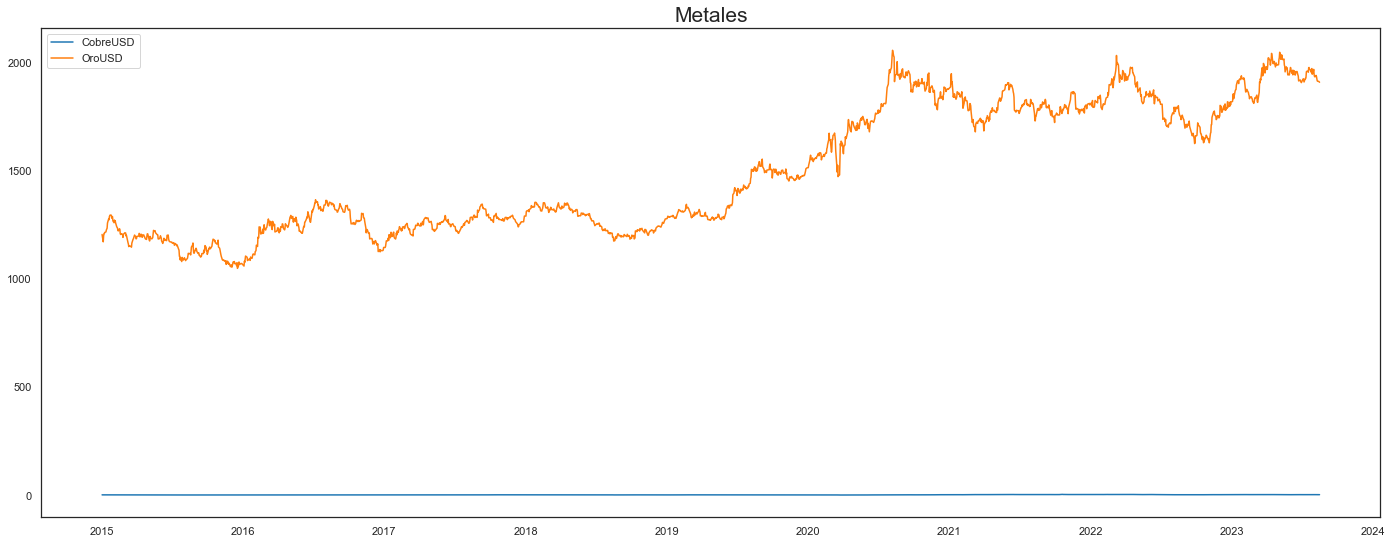

In [33]:
plt.figure(figsize=(24, 9))
#plt.plot(x, y, color='blue', linestyle='--', marker='o', markersize=8, markerfacecolor='red',
#         markeredgecolor='black', markevery=2, linewidth=2, alpha=0.7, label='Datos')
for i in range(len(metales.columns)): 
    plt.plot(metales.index,  metales.iloc[:, i], label=metales.columns[i])

plt.title("Metales", fontsize=21)
plt.legend()
plt.show()

# LEER INDICADORES MONETARIOS

In [34]:
#
# Leer BaseMonetaria, M1, M2 y M3 indicadores monetarios del BCCh
# Se leen desde archivos especificos.
#
Monetarios = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/BaseMonetaria.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","BaseMonetaria"])

#Leer m1
m1 = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/M1.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","M1","Circulante","D1+DVista+AhVista","D1","CC-Empresas","CC-Personas","DVista+AhVista","CV-Personas"])

#Leer DP[Deposito a plazo Personas + Otros], Ahp[Ahorro Personas]
m2 = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/M2.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","DP","Dp-Personas","Dp-Otros","Ahp"])

#Leer Doc-BCCh [1.Documentos del Banco Central de Chile],Bonos-TGR[1.Documentos del Banco Central de Chile], LetrasCredito[3.Letras de crédito],Dep-ME[4.Dep. moneda extranjera]
m3 = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/M3.xlsx", "2013-01-02", "2023-08-16","excel","left", ["Date","Doc-BCCh","Bonos-TGR","LetrasCredito","Dep-ME"])

#Calula M2 
m2["M2"] = m2["DP"]+ m2["Ahp"] 
m2.drop(["DP","Dp-Personas","Dp-Otros","Ahp"], axis=1, inplace=True)

#Calula M3 
#Leer Doc-BCCh [1.Documentos del Banco Central de Chile],Bonos-TGR[1.Documentos del Banco Central de Chile], LetrasCredito[3.Letras de crédito],Dep-ME[4.Dep. moneda extranjera]
m3["M3"] = m3["Doc-BCCh"]+ m3["Bonos-TGR"]+ m3["LetrasCredito"] + m3["Dep-ME"]
m3.drop(["Doc-BCCh","Bonos-TGR","LetrasCredito","Dep-ME"], axis=1, inplace=True)


#Agregar al data frame Monetarios, las columnas M1, M2 y M3, usando la fecha como indice.
Monetarios = Monetarios.merge(m1['M1'], how="left", left_on="Date", right_on="Date")
Monetarios = Monetarios.merge(m2, how="left", left_on="Date", right_on="Date")
Monetarios = Monetarios.merge(m3, how="left", left_on="Date", right_on="Date")

#Eliminar dias sin datos (fines de semana y feriados)
Monetarios.dropna(axis='rows',how='all',inplace=True)
Monetarios.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/Monetarios.xlsx', index = True)

print(Monetarios.tail(5))
print(Monetarios.head(5))
#print("IsNull:")
#print(Monetarios.isnull().sum())
#print("IsNA:")
#print(Monetarios.isna().sum())
#print("dtypes:")
#print(Monetarios.dtypes)
#print('Describe')
Monetarios.describe()



            BaseMonetaria            M1             M2            M3
Date                                                                
2023-07-25   17428.784449  54349.827997  123475.567464  93777.523937
2023-07-26   16925.854732  54844.029132  123678.906702  94310.281916
2023-07-27   17530.081814  55718.063123  123261.255526  92434.965594
2023-07-28   16496.130167  55737.111429  123450.919151  91965.896109
2023-07-31   24947.408537  55907.037385  123440.091134  92987.803727
            BaseMonetaria            M1            M2            M3
Date                                                               
2015-01-02    8225.144905  26543.776952  73120.991776  37837.630987
2015-01-05    8057.839276  26204.213674  72874.106833  37845.825973
2015-01-06    8278.144114  25973.851968  73110.254144  37932.053190
2015-01-07    8127.611830  25701.382721  73231.417606  38553.951147
2015-01-08    8013.294293  25915.710856  73340.813458  38777.129423


,BaseMonetaria,M1,M2,M3
count,2140.000000,2140.000000,2140.000000,2140.000000
mean,15227.716922,44550.514433,92769.419879,63368.782660
std,6680.417716,17720.296186,11888.066250,17409.403603
min,7950.392581,24621.715425,72434.972862,37837.630987
25%,10182.645197,29491.678593,84707.510026,50188.151903
50%,11912.294602,36035.750733,89527.900895,58497.119539
75%,19679.209976,59248.343756,100504.200579,75196.725033
max,40207.663155,83269.387097,123881.746121,100777.996018


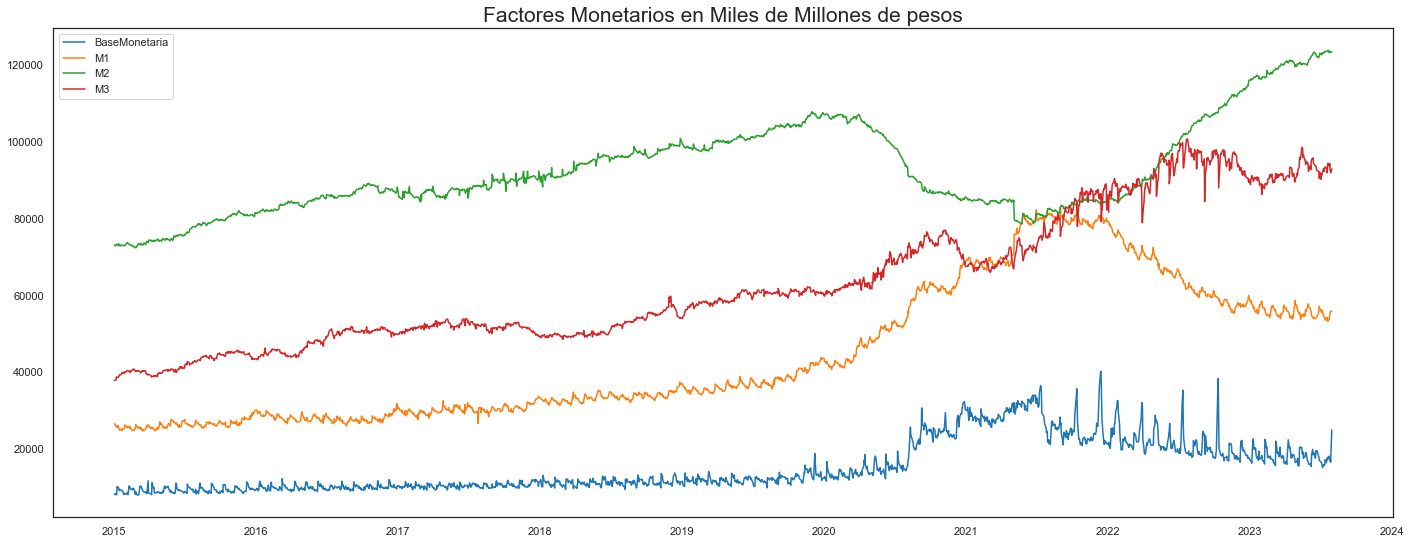

In [35]:
plt.figure(figsize=(24, 9))
for i in range(len(Monetarios.columns)):  #numero de columnas 
    plt.plot(Monetarios.index,  Monetarios.iloc[:, i], label=Monetarios.columns[i])

plt.title("Factores Monetarios en Miles de Millones de pesos", fontsize=21)
plt.legend()
plt.show()

In [36]:
#
# Analizaremos graficamente desde Agosto del 2022 en adelante (ultimo año)
#

MonetariosFiltrado = Monetarios[(Monetarios.index >= fechabase_filtro_analisis) & (Monetarios.index <= fechafin_filtro_analisis)]



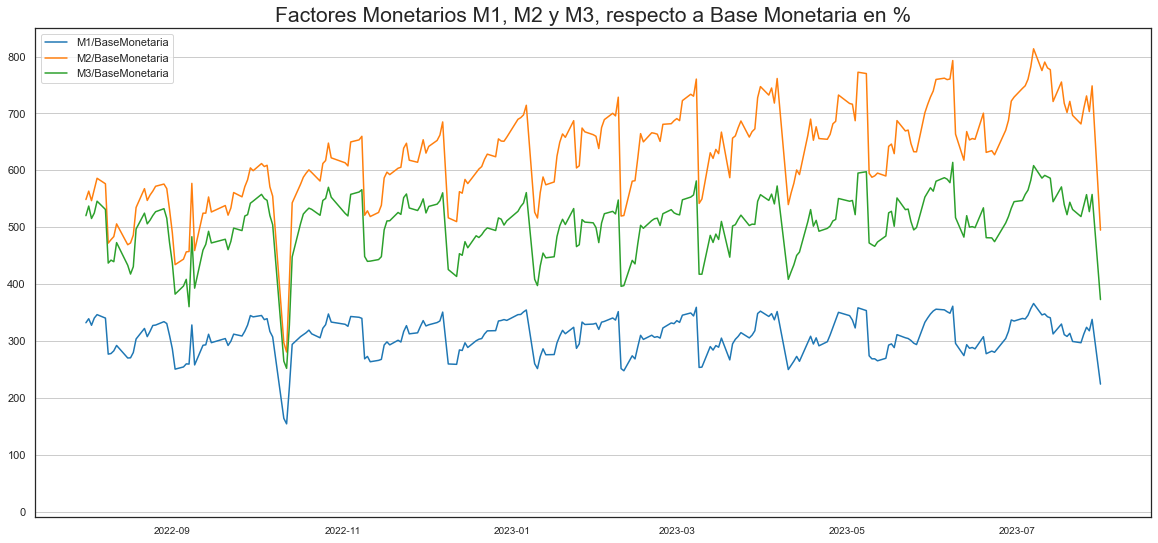

In [37]:
plt.figure(figsize=(20, 9))
for i in range(1, 4):  #numero de columnas 
    plt.plot(MonetariosFiltrado.index,  (MonetariosFiltrado.iloc[:, i]/MonetariosFiltrado.iloc[:, 0])*100, label=MonetariosFiltrado.columns[i]+"/BaseMonetaria")
plt.title("Factores Monetarios M1, M2 y M3, respecto a Base Monetaria en %", fontsize=21)
plt.tick_params('x', labelsize=10)
plt.ylim(-10,850)
plt.grid(axis='y', color='0.8')
plt.legend()
plt.show()

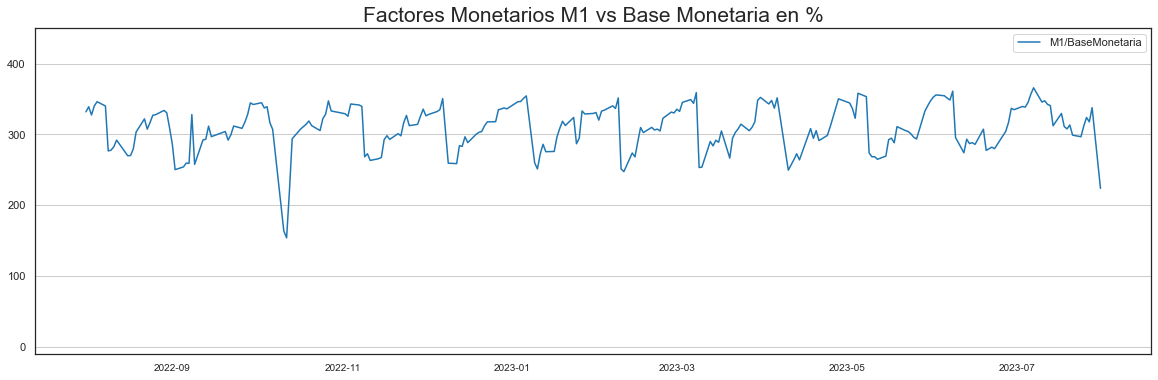

In [38]:
plt.figure(figsize=(20, 6))
plt.plot(MonetariosFiltrado.index, (MonetariosFiltrado.iloc[:, 1]/MonetariosFiltrado.iloc[:, 0])*100, label=MonetariosFiltrado.columns[1]+"/BaseMonetaria")
plt.title("Factores Monetarios M1 vs Base Monetaria en %", fontsize=21)
plt.tick_params('x', labelsize=10)
plt.ylim(-10,450)
plt.grid(axis='y', color='0.8')
plt.legend()
plt.show()

# LEER INDICADORES ECONOMICOS (fuente BCCh)


In [39]:
#Valor UF
uf = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/UF-Valor.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","UF"])
uf.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/UF.xlsx', index = True)

#Tasa de politica Monetaria
tpm = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/TPM.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","TPM"])
uf.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/TPM.xlsx', index = True)

#Tasa Interbancaria
tib = getDatosSeriesUnico("./PronosticoSerieTiempo-Stocks-Cryptos/BCChIndicadorEconomico/TIB.xlsx", "2015-01-02", "2023-08-16","excel","left", ["Date","TIB"])
tib.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/TIB.xlsx', index = True)

#Unir todos los indicadores economicos.
indicesEconomicos  = uf
indicesEconomicos = indicesEconomicos.merge(tpm, how="left", left_on="Date", right_on="Date")
indicesEconomicos = indicesEconomicos.merge(tib, how="left", left_on="Date", right_on="Date")
indicesEconomicos = indicesEconomicos.fillna(method='ffill') #completa los valores faltantes, con el ultimo valor

#Eliminara la fila si existe al menos 2 de las 3 columnas con valore nulo.
indicesEconomicos = indicesEconomicos.dropna(thresh=indicesEconomicos.shape[1] - 1)  

indicesEconomicos.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/IndicesEconomicos.xlsx', index = True)


print(indicesEconomicos.tail(5))
print(indicesEconomicos.head(5))
#print("IsNull:")
#print(indicesEconomicos.isnull().sum())
#print("IsNA:")
#print(indicesEconomicos.isna().sum())
indicesEconomicos.describe()

                  UF    TPM    TIB
Date                              
2023-08-12  36042.02  10.25  10.25
2023-08-13  36046.66  10.25  10.25
2023-08-14  36051.31  10.25  10.25
2023-08-15  36055.95  10.25  10.25
2023-08-16  36060.59  10.25  10.25
                 UF  TPM  TIB
Date                         
2015-01-02  24627.1  3.0  3.0
2015-01-03  24627.1  3.0  3.0
2015-01-04  24627.1  3.0  3.0
2015-01-05  24627.1  3.0  3.0
2015-01-06  24627.1  3.0  3.0


,UF,TPM,TIB
count,3149.000000,3149.000000,3149.000000
mean,28580.029724,3.691807,3.664182
std,3075.293217,3.136723,3.153558
min,24528.590000,0.500000,0.300000
25%,26387.390000,2.500000,2.490000
50%,27639.180000,3.000000,2.950000
75%,29680.180000,3.500000,3.500000
max,36100.300000,11.250000,11.250000


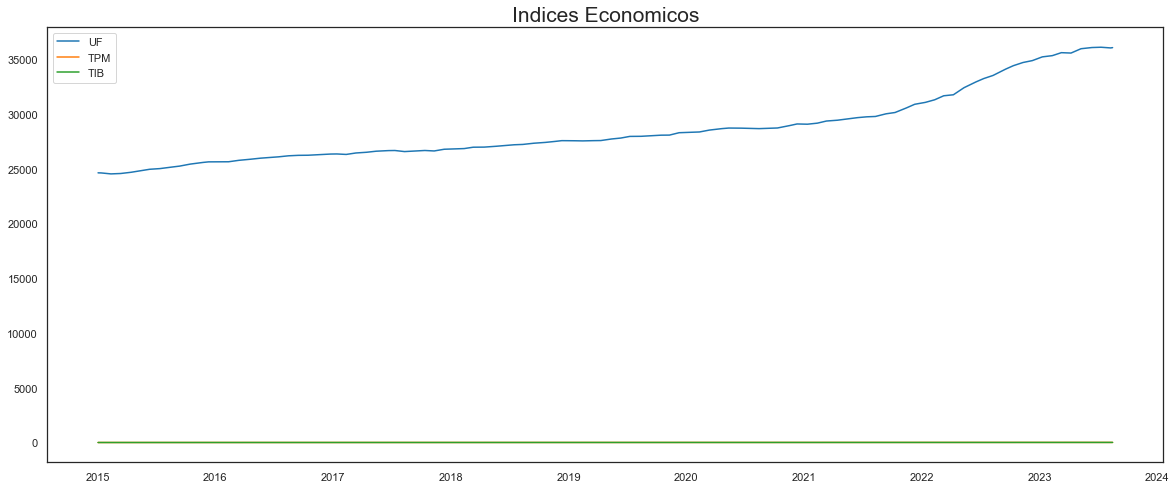

In [40]:
plt.figure(figsize=(20, 8))
for i in range(len(indicesEconomicos.columns)): 
    plt.plot(indicesEconomicos.index,  indicesEconomicos.iloc[:, i], label=indicesEconomicos.columns[i])

plt.title("Indices Economicos", fontsize=21)
plt.legend()
plt.show()

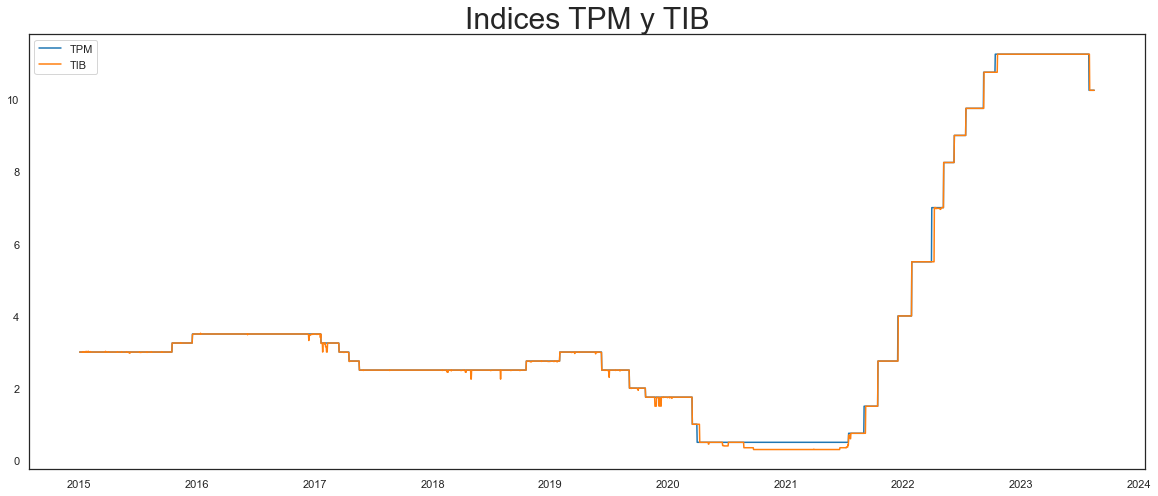

In [70]:
plt.figure(figsize=(20, 8))
for i in range(1,len(indicesEconomicos.columns)): 
    plt.plot(indicesEconomicos.index,  indicesEconomicos.iloc[:, i], label=indicesEconomicos.columns[i])
plt.title("Indices TPM y TIB", fontsize=30)
plt.legend()
plt.show()

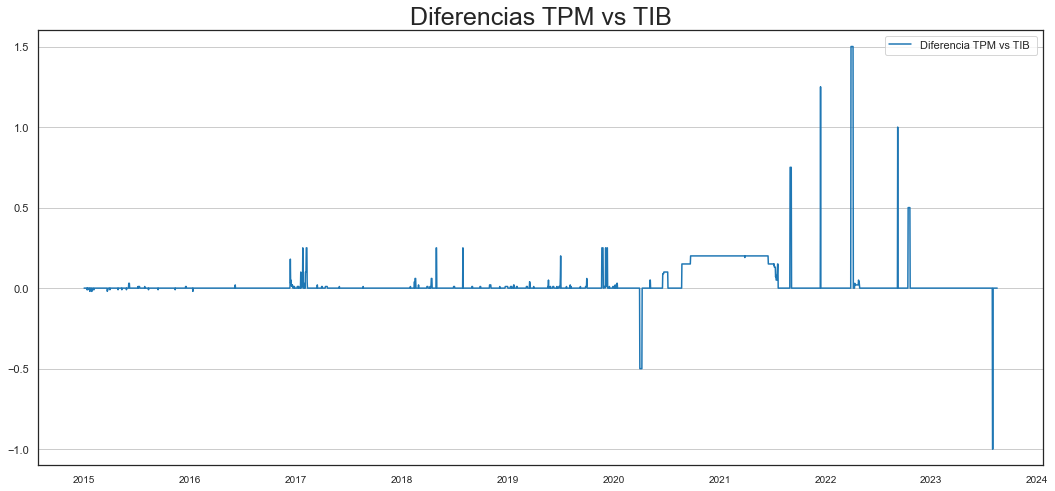

In [42]:
plt.figure(figsize=(18, 8))
plt.plot(indicesEconomicos.index,  indicesEconomicos.iloc[:, 1] - indicesEconomicos.iloc[:, 2] , label="Diferencia TPM vs TIB ")
plt.title("Diferencias TPM vs TIB", fontsize=25)
plt.tick_params('x', labelsize=10)
plt.ylim(-1.1,1.6)
plt.grid(axis='y', color='0.8')
#plt.grid(axis='x', color='0.8')
plt.legend()
plt.show()

Se puede observar que en 2023, en algunos momentos la TPM esta detras de la TIB, lo usual es que que BCCh tenga una TPM > TIB para dirigir la politica monetaria.

## LEER PRECIOS CIERRE ACCIONES CHILENAS DEL PORTAFOLIO (en CLP)

In [43]:
path = str("./PronosticoSerieTiempo-Stocks-Cryptos/Acciones/*.csv")
acciones = getDatosSeries(path, start_time_serie, end_time_serie,"csv","left", ["Date","Close"])
acciones.dropna(axis='rows',how='all',inplace=True)
#acciones = acciones.fillna(method='ffill')
acciones.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/Acciones_portafolio.xlsx', index = True)

print(acciones.tail(5))
print(acciones.head(5))
#print("\nIsNull:\n",acciones.isnull().sum())
#print("\nIsNA:\n",acciones.isna().sum())
acciones.describe()

              FALABELLA       SONDA
Date                               
2023-08-09  2329.000000  442.750000
2023-08-10  2295.000000  449.390015
2023-08-11  2289.000000  445.239990
2023-08-14  2280.000000  440.470001
2023-08-16  2253.100098  440.000000
              FALABELLA        SONDA
Date                                
2017-01-03  5321.700195  1198.000000
2017-01-04  5324.899902  1173.599976
2017-01-05  5276.600098  1170.900024
2017-01-06  5311.500000  1177.199951
2017-01-09  5265.399902  1157.900024


,FALABELLA,SONDA
count,1648.000000,1648.000000
mean,3712.477970,702.111869
std,1554.097657,340.679824
min,1518.400024,230.220001
25%,2349.524963,401.967499
50%,3160.000000,580.829986
75%,5314.800049,1061.449951
max,6498.399902,1308.400024


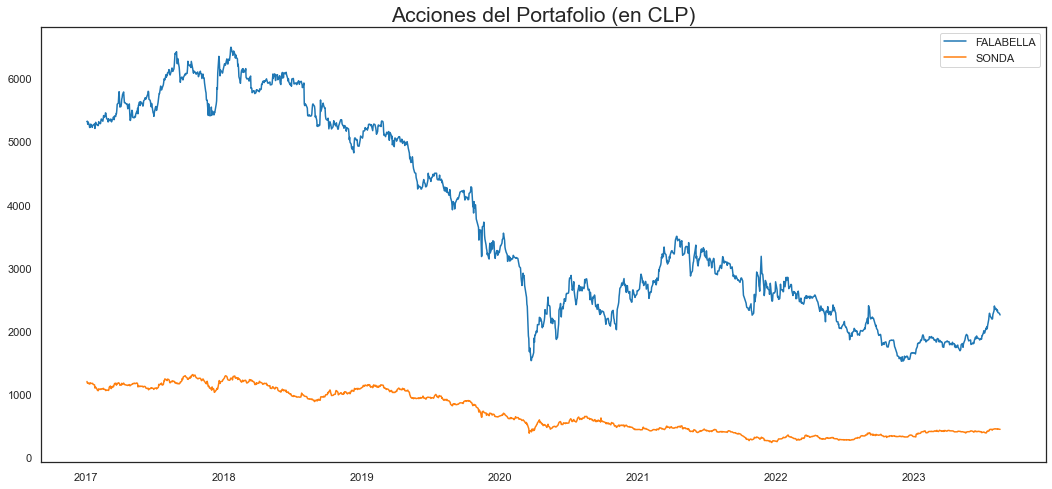

In [44]:
plt.figure(figsize=(18, 8))
 
for i in range(len(acciones.columns)): 
    plt.plot(acciones.index,  acciones.iloc[:, i], label=acciones.columns[i])

plt.title("Acciones del Portafolio (en CLP)", fontsize=21)
plt.legend()
plt.show()

## Generar el dataframe con todas las variables predictoras

In [45]:
find_first_date(acciones,True)
print("\n\n")
variablesPredictoras = pd.DataFrame(pd.date_range(start_time_serie,end_time_serie, freq="d"), columns=["Date"])
variablesPredictoras.set_index("Date", inplace=True)

variablesPredictoras = variablesPredictoras.merge(metales, how="left", left_on="Date", right_on="Date")
variablesPredictoras = variablesPredictoras.merge(Monetarios, how="left", left_on="Date", right_on="Date")
variablesPredictoras = variablesPredictoras.merge(indicesEconomicos, how="left", left_on="Date", right_on="Date")

variablesPredictoras.dropna(axis='rows',inplace=True)
#print("IsNull",variablesPredictoras.isnull().sum())
#print("IsNA",variablesPredictoras.isna().sum())
variablesPredictoras.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/VariablesPredictoras_raw.xlsx', index = True)
#print(variablesPredictoras.head(10))
#print(variablesPredictoras.tail(10))
variablesPredictoras.head(10)
#variablesPredictoras.describe()


La primera fecha de la serie de tiempo es:[ 2017-01-03 00:00:00 ]
La ultima fecha de la serie de tiempo es :[ 2023-08-16 00:00:00 ]





,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB
Date,,,,,,,,,
2017-01-03,2.48,1145.90,10331.338847,30760.770745,85601.312371,49952.940290,26350.53,3.5,3.50
2017-01-04,2.51,1151.00,10175.895646,30387.480195,85695.133857,49901.742898,26351.38,3.5,3.50
2017-01-05,2.49,1164.25,10226.334464,30304.427807,85599.948202,50364.726872,26352.23,3.5,3.50
2017-01-06,2.55,1176.70,9872.782366,29970.630433,85439.401309,50382.196863,26353.08,3.5,3.49
2017-01-09,2.52,1175.85,10155.839117,29997.498068,85195.298814,50505.831450,26355.63,3.5,3.50
2017-01-10,2.53,1178.50,10075.714531,29628.015315,85200.584409,50374.274159,26353.93,3.5,3.49
2017-01-11,2.53,1189.50,9605.677170,30037.898116,85253.903462,49972.893468,26352.23,3.5,3.49
2017-01-12,2.60,1178.55,10082.191928,29875.128360,85086.066065,50127.976107,26350.52,3.5,3.50
2017-01-13,2.58,1205.05,10148.688813,29398.067357,87089.890892,50586.832845,26348.82,3.5,3.50


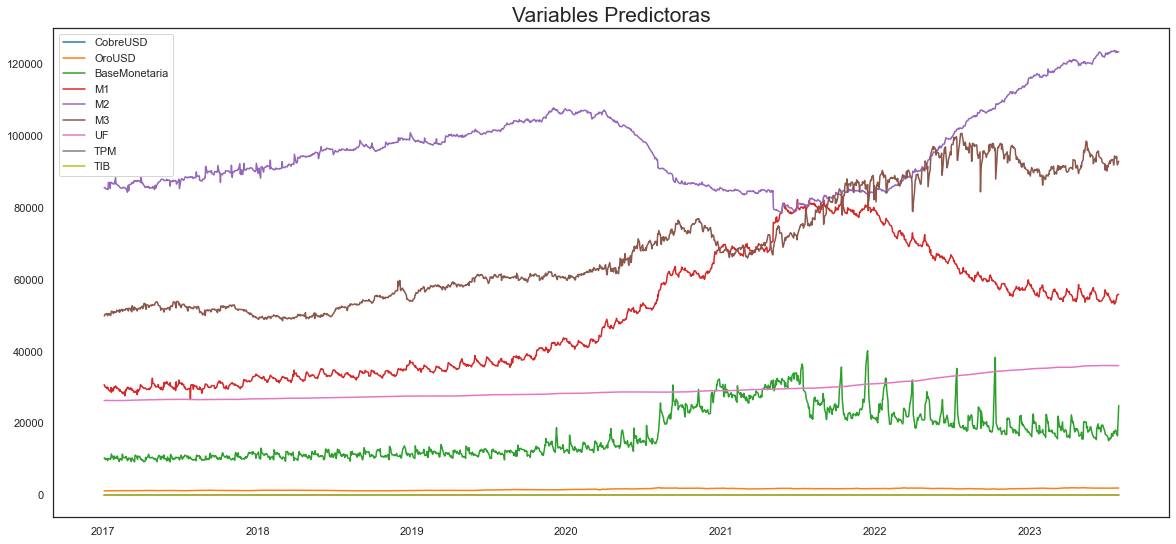

In [46]:
plt.figure(figsize=(20, 9))
for i in range(0, 9): 
    plt.plot(variablesPredictoras.index,  variablesPredictoras.iloc[:, i], label=variablesPredictoras.columns[i])
plt.title("Variables Predictoras", fontsize=21)
plt.legend()
plt.show()

In [48]:
# Filtrar y eliminar las filas que cumplan la condición de fecha
accionesChile, factoresEconomicos = clean_data(acciones, variablesPredictoras)
print("\n-----------Portafolio Acciones - Despues de limpiar datos---------")
#print("\nIsNull:\n",accionesChile.isnull().sum())
#print("\nIsNA:\n",accionesChile.isna().sum())
#print("\nDescribe:\n\n",accionesChile.describe())
print(accionesChile)
print("\n-----------Factores Economicos - Despues de limpiar datos---------")
#print("\nIsNull:\n\n",factoresEconomicos.isnull().sum())
#print("\nIsNA:\n\n",factoresEconomicos.isna().sum())
#print("\nDescribe:\n\n",factoresEconomicos.describe())
print(factoresEconomicos)



La primera fecha de la serie de tiempo es:[ 2017-01-03 00:00:00 ]
La ultima fecha de la serie de tiempo es :[ 2023-08-16 00:00:00 ]

-----------Portafolio Acciones - Despues de limpiar datos---------
              FALABELLA        SONDA
Date                                
2017-01-03  5321.700195  1198.000000
2017-01-04  5324.899902  1173.599976
2017-01-05  5276.600098  1170.900024
2017-01-06  5311.500000  1177.199951
2017-01-09  5265.399902  1157.900024
...                 ...          ...
2023-08-09  2329.000000   442.750000
2023-08-10  2295.000000   449.390015
2023-08-11  2289.000000   445.239990
2023-08-14  2280.000000   440.470001
2023-08-16  2253.100098   440.000000

[1648 rows x 2 columns]

-----------Factores Economicos - Despues de limpiar datos---------
            CobreUSD   OroUSD  BaseMonetaria            M1             M2  \
Date                                                                        
2017-01-03      2.48  1145.90   10331.338847  30760.770745   85601.31237

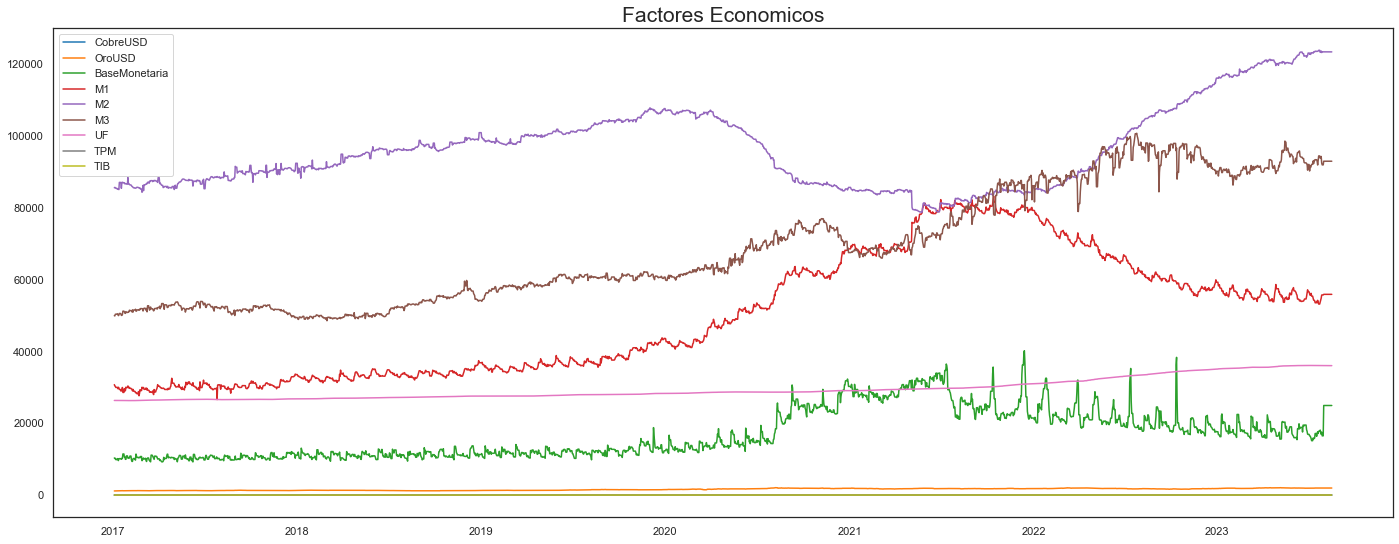

In [50]:
plt.figure(figsize=(24, 9))

for i in range(len(factoresEconomicos.columns)): 
    plt.plot(factoresEconomicos.index,  factoresEconomicos.iloc[:, i], label=factoresEconomicos.columns[i])

plt.title("Factores Economicos", fontsize=21)
plt.legend()
plt.show()

# Forecast/Pronosticos usando Serie de Tiempo

## *Que es una Serie de Tiempo*

Una serie de tiempo es una secuencia numérica de observaciones sobre un evento tomadas secuencialmente en el tiempo y consta de dos elementos esenciales: **tiempo** y **valor**. El elemento de tiempo puede ser cualquier período de tiempo, como anualmente, trimestralmente, mensualmente, diariamente, cada hora o cada minuto. Sin embargo, lo más importante es que el **intervalo entre las observaciones debe ser constante**.

El elemento de valor puede ser cualquier observación, como la detección horaria de un sensor de temperatura o las ventas anuales de una empresa. Por ejemplo, la siguiente serie temporal de ventas de una tienda de comestibles es una serie temporal de período, que cuenta las ventas totales de la tienda de comestibles para cada año dentro de un período de un año.
## *Como funciona la serie de tiempo*

El pronóstico de series de tiempo es el proceso de analizar datos de series de tiempo ${Y(t)}$ utilizando estadísticas y modelos para hacer predicciones y decisiones estratégicas informadas. En estadística, lo llamamos pronóstico cuantitativo. En un entorno de pronóstico, nos encontraremos en el momento ${t}$ y estamos interesados ​​en estimar ${Y(t+h)}$, utilizando solo la información disponible en el momento ${t}$. Hay muchas maneras de lograrlo, pero en este proyecto guiado, solo discutiremos los pronósticos de series de tiempo de una sola variable que utilizan solo los valores históricos de sí mismos para predecir valores futuros, lo que significa que nuestros modelos de pronóstico se basan en el análisis de autorregresión.

Antes de comenzar a construir el modelo de pronóstico de series de tiempo, necesitamos saber que se cree que los datos de una serie de tiempo determinada constan de cuatro componentes sistemáticos, que incluyen **tendencia (Trend)**, **estacionalidad (Seasonality)**, **ciclicidad (Cyclicality)** y **ruido (Noise)**.


- Trend (${T}$): Se refiere a series que exhiben una tendencia continua hacia arriba o hacia abajo durante un período de tiempo considerable.

- Seasonality (${S}$): se refiere a los cambios cíclicos en los valores de los indicadores debido a cambios estacionales. Los cambios estacionales en los valores de los indicadores son anuales y generalmente se miden en semanas, meses o trimestres, no en años.

- Cyclicality(${C}$): Se diferencia de la variación estacional en que la variación cíclica puede ocurrir durante varios años.

- Noise(${e}$): Se refiere a la variación aleatoria en la serie.

Si los componentes pudieran ser independientes unos de otros, entonces podemos considerar el $${Modelo \space Aditivo }$$ 

$${y_t}= {T_t + S_t + C_t + e_t}$$

Si los componentes dependen unos de otros, entonces podemos considerar el $${Modelo \space Multiplicativo}$$ 

$${y_t}= {T_t \times S_t \times C_t \times e_t}$$


NOTA: En este proyecto contamos con la función **<code>decompose</code>** para descomponer rápidamente los datos de las series de tiempo en los componentes arriba indicados y presentarlos en forma grafica.


# PROCESO DE PRONOSTICO DE LA SERIE DE TIEMPO

 ### INTRODUCCION AL MODELO ARIMA

Como podemos ver por el nombre, este es un modelo hecho por otros dos modelos: **modelos autorregresivos** y de **promedio móvil**.

El **modelo autorregresivo** puede pronosticar una serie de tiempo  ${y_t}$  basado únicamente en las observaciones pasadas  ${y_{t-1} ,y_{t-2}, \cdot\cdot\cdot ,y_{t-p}}$ en la serie, y la ecuación es $${y_t} = {c + \Phi_1y_{t-1} + \Phi_2y_{t-2} + \cdot\cdot\cdot + \Phi_py_{t-p} + \epsilon_t}$$

 
El **modelo de promedio móvil** puede pronosticar una serie de tiempo basándose únicamente en los errores pasadosen la serie, y la ecuación del promedio móvil es:

$${y_t} = {c + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdot\cdot\cdot + \theta_p\epsilon_{t-p}}$$

 
Si juntamos los modelos AR y MA con la primera diferenciación, obtendremos la ecuación del modelo ARIMA donde la parte izquierda de la ecuación es autorregresiva, y la parte derecha de la ecuación es el promedio móvil que se muestra a continuación:

$${y^{'}_t} = {c + \Phi_1y^{'}_{t-1} + \cdot\cdot\cdot + \Phi_py^{'}_{t-p} + \theta_1\epsilon_{t-1} + \cdot\cdot\cdot + \theta_p\epsilon_{t-p} + \epsilon_t}$$

 
- ${y_t}$: valor de la serie temporal en el tiempo t.

- ${{y_0}',...,{y_{t-2}}',{y_{t-1}}'}$:  valores de series de tiempo diferenciados en el tiempo 0,…,t-2, t-1

### Casos de pronosticos que se realizan en este proyecto:

A continuación realizaremos los siguientes casos de pronosticos:
        
- Pronostico de la Serie de Tiempo usando ARIMA e indice de portafolio de igual ponderación (equal-weighted)

- Pronostico de la Serie de Tiempo usando SARIXMA e indice de portafolio de igual ponderación (equal-weighted)

- Pronostico de la Serie de Tiempousando SARIXMA e indice de portafolio de capital ponderado (Capitalization-Weighted)

#  Pronostico de la Serie de Tiempo usando ARIMA e indice de portafolio de igual ponderación (equal-weighted)

- (1.a) Se calculará el indice equal-weighted (igual ponderación), para el portafolio de acciones
- (1.b) Posteriormente se dividirá la serie de datos entre datos de entrenamiento y prueba
- (1.c) Se realizará la generación del modelo ARIMA y los correspondientes pronosticos-
- (1.d) Analisis de los resultados y evaluación.


#### (1.a) Calculo del equal-weighted index:

Un indice **Equal-Weighted** (índice ponderado por **igual**) es un tipo de índice financiero en el que cada componente individual (acción, título o activo) tiene el mismo peso o importancia en la composición del índice, independientemente de su capitalización de mercado. 
A diferencia de los indices **Capitalization-Weighted**(ponderados por **capitalización de mercado** ), donde las empresas más grandes tienen un mayor peso, los índices equal-weighted asignan la misma ponderación a cada componente, lo que significa que cada activo contribuye igualmente al rendimiento general del índice. 

El calculo del indice **Equal-Weighted** se realiza con:


$${V} = {({P}_{1}{W}_{1}) + ({P}_{2}{W}_{2}) + ... +({P}_{n}{W}_{n})}$$

- Valor del Indice (${V}$): equal-weighted index o indice de igual ponderación

- Precio(${P}$): indica el precio de la accion

- Weight(${W}$): peso asignado, pero en un índice con igual ponderación, cada ponderación es 1/N, siendo N el número de criptomonedas dentro del índice.




In [51]:
result = []
# calculando el index value

for i in range(len(accionesChile.columns)):
    stock = accionesChile[accionesChile.columns[i]] / len(accionesChile.columns)
    result.append(stock)

# Asignado el index value a las fechas, concatena sumando las columnas del dataframe.
ew_indice = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
ew_indice.set_axis([*ew_indice.columns[:-1], "Index"], axis=1, inplace=True)
ew_indice['Date'] = pd.to_datetime(ew_indice.index)  # Convertir la columna 'fecha' a tipo datetime
ew_indice.set_index('Date', inplace=True)  # Fecha como indice
ew_indice = ew_indice.sort_index()
#ew_index = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
#ew_index.set_axis([*ew_index.columns[:-1], "Index"], axis=1, inplace=True)
print(accionesChile.tail(5))
ew_indice.tail(5)


              FALABELLA       SONDA
Date                               
2023-08-09  2329.000000  442.750000
2023-08-10  2295.000000  449.390015
2023-08-11  2289.000000  445.239990
2023-08-14  2280.000000  440.470001
2023-08-16  2253.100098  440.000000


,Index
Date,
2023-08-09,1386.875000
2023-08-10,1373.195007
2023-08-11,1368.119995
2023-08-14,1361.235001
2023-08-16,1347.550049


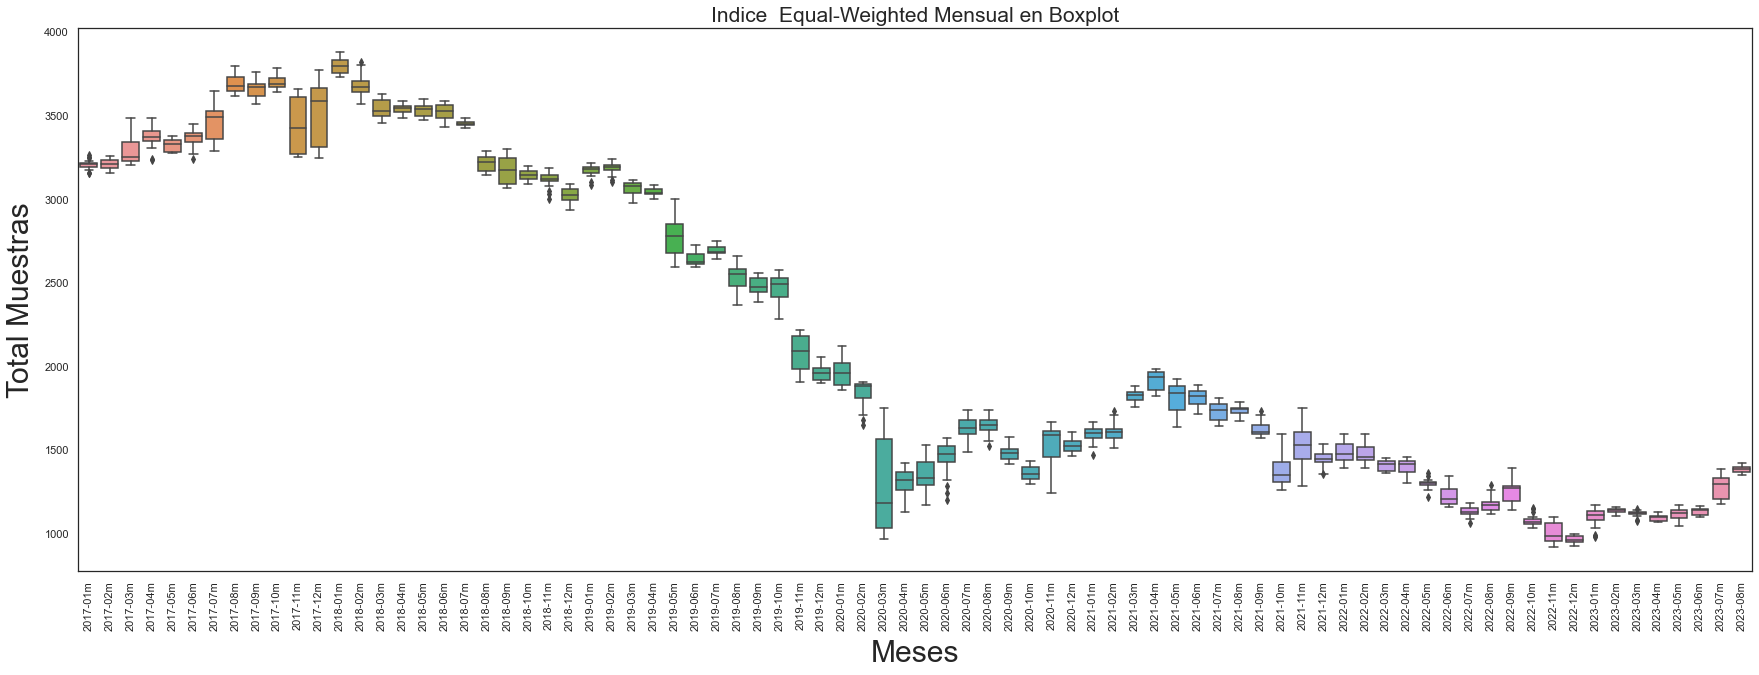

In [52]:
ts_fig, ts_ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x=ew_indice.index.strftime("%Y-%mm"), y=ew_indice["Index"], ax=ts_ax)
ts_ax.set_xlabel("Meses", labelpad=9, fontsize=30)
ts_ax.set_ylabel("Total Muestras", labelpad=9, fontsize=30)
ts_ax.set_xticklabels(ts_ax.get_xticklabels(), rotation=90)
ts_ax.set_title("Indice  Equal-Weighted Mensual en Boxplot", fontsize=21)
plt.show()


 ### Normalizar la serie de tiempo y generar correlaciones

In [53]:
dataSerieTiempo = pd.DataFrame(pd.date_range(start_date, end_date, freq="d"), columns=["Date"])
dataSerieTiempo = dataSerieTiempo.merge(factoresEconomicos, how="left", left_on='Date', right_on='Date')
#dataSerieTiempo = dataSerieTiempo.merge(ew_indice.Index, how="left", left_on='Date', right_on='Date')
dataSerieTiempo = dataSerieTiempo.merge(ew_indice.Index, how="left", left_on='Date', right_on='Date')

dataSerieTiempo.set_index("Date", inplace=True)
dataSerieTiempo = dataSerieTiempo.dropna()
print(dataSerieTiempo.dtypes)
print(dataSerieTiempo)

CobreUSD         float64
OroUSD           float64
BaseMonetaria    float64
M1               float64
M2               float64
M3               float64
UF               float64
TPM              float64
TIB              float64
Index            float64
dtype: object
            CobreUSD   OroUSD  BaseMonetaria            M1             M2  \
Date                                                                        
2017-01-03      2.48  1145.90   10331.338847  30760.770745   85601.312371   
2017-01-04      2.51  1151.00   10175.895646  30387.480195   85695.133857   
2017-01-05      2.49  1164.25   10226.334464  30304.427807   85599.948202   
2017-01-06      2.55  1176.70    9872.782366  29970.630433   85439.401309   
2017-01-09      2.52  1175.85   10155.839117  29997.498068   85195.298814   
...              ...      ...            ...           ...            ...   
2023-08-09      3.87  1959.93   24947.408537  55907.037385  123440.091134   
2023-08-10      3.87  1959.93   24947.40853

In [100]:
#
# Se escalan los valores a MinMaxScaler()  y eliminan correlaciones debiles ( entre -0.2 to 0.2)
#
dataSerieTiempo_normalizada , correlaciones = prepare_data(dataSerieTiempo)
dataSerieTiempo_normalizada.tail(5)

print("\nCorrelaciones de la Serie de tiempo normalizada:\n")
correlaciones.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)



Correlaciones de la Serie de tiempo normalizada:



,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB,Index
CobreUSD,1.00,0.92,0.94,0.97,-0.18,0.85,0.69,0.25,0.24,-0.84
OroUSD,0.92,1.00,0.91,0.95,0.08,0.95,0.83,0.40,0.38,-0.98
BaseMonetaria,0.94,0.91,1.00,0.99,-0.33,0.75,0.55,0.02,0.01,-0.81
M1,0.97,0.95,0.99,1.00,-0.22,0.83,0.65,0.15,0.13,-0.88
M2,-0.18,0.08,-0.33,-0.22,1.00,0.34,0.58,0.87,0.88,-0.27
M3,0.85,0.95,0.75,0.83,0.34,1.00,0.96,0.67,0.66,-0.98
UF,0.69,0.83,0.55,0.65,0.58,0.96,1.00,0.84,0.83,-0.91
TPM,0.25,0.40,0.02,0.15,0.87,0.67,0.84,1.00,1.00,-0.54
TIB,0.24,0.38,0.01,0.13,0.88,0.66,0.83,1.00,1.00,-0.53
Index,-0.84,-0.98,-0.81,-0.88,-0.27,-0.98,-0.91,-0.54,-0.53,1.00


In [101]:
print("\n Serie de tiempo normalizada (Se eliminaron las correlaciones debiles entre -0.2 to 0.2):\n")
print(dataSerieTiempo_normalizada)
dataSerieTiempo_normalizada.describe()



 


 Serie de tiempo normalizada (Se eliminaron las correlaciones debiles entre -0.2 to 0.2):

            CobreUSD    OroUSD  BaseMonetaria        M1        M2        M3  \
Date                                                                          
2017-01-03  0.125413  0.000000       0.035145  0.073422  0.152842  0.026827   
2017-01-04  0.135314  0.005598       0.030125  0.066835  0.154918  0.025847   
2017-01-05  0.128713  0.020143       0.031754  0.065369  0.152811  0.034712   
2017-01-06  0.148515  0.033810       0.020336  0.059479  0.149258  0.035046   
2017-01-09  0.138614  0.032877       0.029477  0.059953  0.143856  0.037413   
...              ...       ...            ...       ...       ...       ...   
2023-08-09  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-10  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-11  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-14  0.584158  0.893576       0.

,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB,Index
count,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000
mean,0.402396,0.484097,0.251296,0.411821,0.394862,0.394325,0.327695,0.308958,0.318805,0.439425
std,0.226354,0.300111,0.217452,0.298751,0.248666,0.308324,0.298565,0.332008,0.328879,0.313364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.203795,0.160245,0.064113,0.127879,0.179383,0.098478,0.100076,0.116279,0.132420,0.165443
50%,0.326733,0.566363,0.173057,0.380610,0.379888,0.291870,0.240974,0.186047,0.200913,0.325837
75%,0.595710,0.749501,0.408373,0.637594,0.559534,0.729142,0.474751,0.325581,0.337900,0.763662
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# PRONOSTICO CON LA SERIE DE TIEMPO

Para construir un modelo de pronóstico de series de tiempo, se deben obtener los datos de una serie de tiempo en sus cuatro componentes sistemáticos, que incluyen **tendencia**, **estacionalidad**, **ciclicidad** y **ruido**.

- Tendencia (${T}$): La serie de tiempo puede presentar una tendencia continua hacia arriba o hacia abajo, durante un período de tiempo.

- Estacionalidad (${S}$): Son los cambios cíclicos en los valores debido a "cambios estacionales". Los "cambios estacionales" se miden en semanas, meses o trimestres y no en años.

- Ciclicidad (${C}$): A diferencia de la variación por Estacionalidad, la variación cíclica puede ocurrir durante varios años.

- Ruido(${e}$): Corresponda a la variacion aleatoria en la serie de tiempo.


Si las componentes son independiente una de otras, usaremos un **Modelo Aditivo** : $${y_t}= {T_t + S_t + C_t + e_t}$$

Si las componentes pueden depender una de otras, entonces usaremos un **Model Multiplicativo**: $${y_t}= {T_t \times S_t \times C_t \times e_t}$$


Usaremos la funcion <code>decompose</code> para descomponer la serie de tiempo en las componentes indicadas.


Serie de Tiempo - Indice portafolio de igual ponderación (equal-weighted)


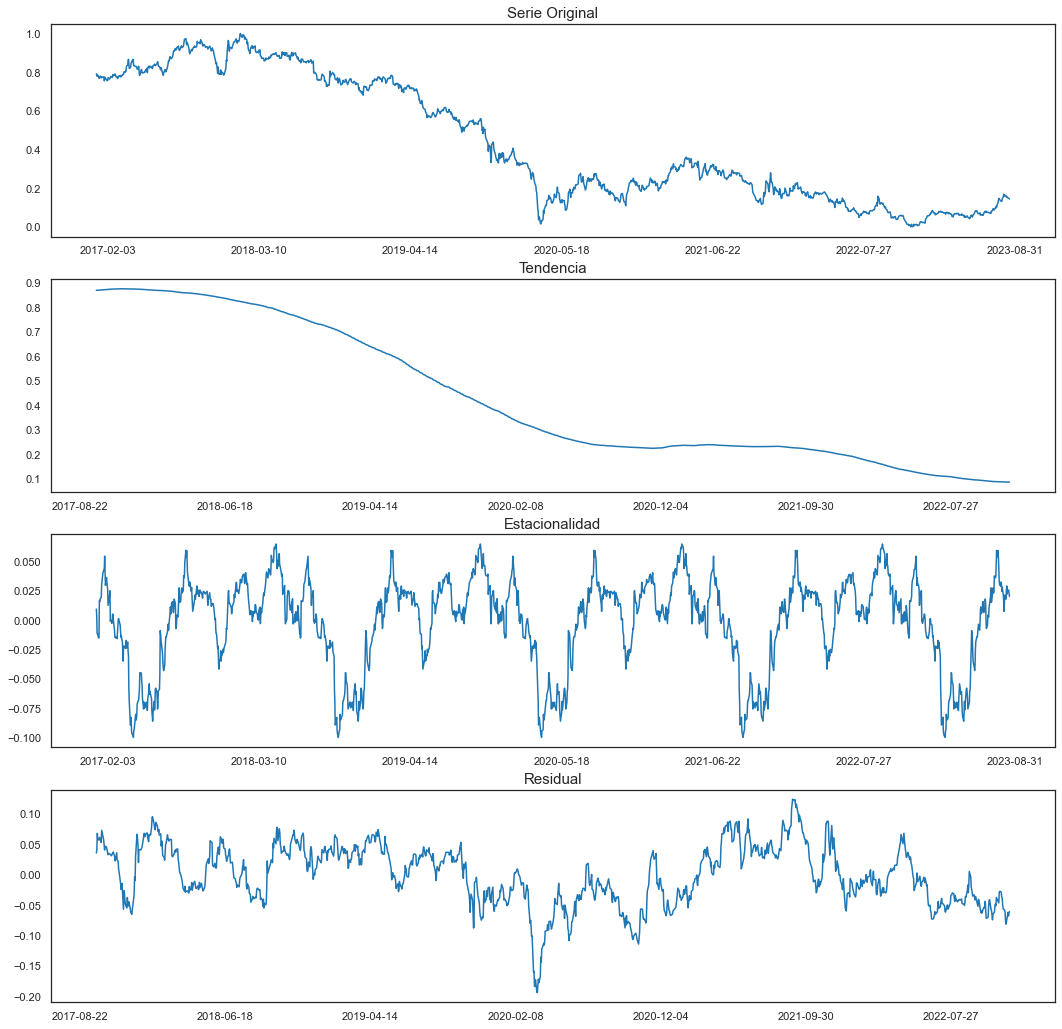

In [56]:
print("Serie de Tiempo - Indice portafolio de igual ponderación (equal-weighted)")
decompose(dataSerieTiempo_normalizada.Index,365)

In [57]:
#Preparar los grupos de pruebas y 
X_train, X_test, y_train, y_test = time_series_split(dataSerieTiempo_normalizada, 0.90)
X_test

,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB
Date,,,,,,,,,
2022-12-21,0.551155,0.739072,0.307450,0.537912,0.776916,0.818882,0.887749,1.000000,1.0
2022-12-22,0.554455,0.737909,0.296391,0.545500,0.782450,0.812257,0.888896,1.000000,1.0
2022-12-23,0.561056,0.712442,0.289076,0.550660,0.788501,0.807834,0.890043,1.000000,1.0
2022-12-26,0.547855,0.718391,0.293607,0.559779,0.789343,0.805088,0.893488,1.000000,1.0
2022-12-27,0.554455,0.716042,0.267321,0.566402,0.799053,0.802314,0.894637,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
2023-08-09,0.584158,0.893576,0.507170,0.517158,0.990226,0.850837,0.995006,0.906977,1.0
2023-08-10,0.584158,0.893576,0.507170,0.517158,0.990226,0.850837,0.995006,0.906977,1.0
2023-08-11,0.584158,0.893576,0.507170,0.517158,0.990226,0.850837,0.995006,0.906977,1.0


In [58]:
y_test
#y_test.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/y_test.xlsx', index = True)

,Index
Date,
2022-12-21,0.014586
2022-12-22,0.019837
2022-12-23,0.025750
2022-12-26,0.026476
2022-12-27,0.023954
...,...
2023-08-09,0.157311
2023-08-10,0.152680
2023-08-11,0.150962


## Implementando Modelo ARIMA

Existen 3 parámetros que podemos sintonizar para el modelo ARIMA: `p`, `d`, `q`:

- $p$: representa el número de observaciones pasadas que deben incluirse.

- $d$: representa el número de diferencias en las observaciones para hacer que una serie de tiempo sea estacionaria.

- $q$: representa el número de términos de errores que deben incluirse.


### Como Determinar el parametro  "d" de estacionariedad

**Estacionario** es un factor que describe la previsibilidad de los datos de series de tiempo. La **estacionaria estricta** **describe toda la distribución de probabilidad como invariante en cambio de tiempo, y la **estacionariedad débil** informa que la media y la covarianza son invariantes en cambio de tiempo, lo que significa que el momento t del valor **depende en gran medida de su historia**. 

En este proyecto usaremos la función estacionaria ( **stationary(y_train)**) para verificar si los datos de la serie temporal son estacionarios.

Y para verificar y obtener evidencia confirmatoria de que nuestra serie temporal es estacionaria o no estacionaria, usaremos una de las pruebas estadísticas de tipo simple (prueba de raíz unitaria) denominada como **prueba de Dickey-Fuller aumentada**.

En la prueba de hipótesis, cuando:

p-value > **0.05** : no se puede rechazar la hipótesis nula (${H_0}$, los datos de la serie temporal no son estacionarios.

p-value <= **0.05** : Rechazar la hipótesis nula (${H_0}$), los datos de la serie temporal son estacionarios.

Serie de Tiempo Original
ADF Statistic: -0.427358
p-value: 0.905430

Diferenciación de primer orden
ADF Statistic: -35.824647
p-value: 0.000000

Diferenciación de Segundo Orden
ADF Statistic: -12.878742
p-value: 0.000000



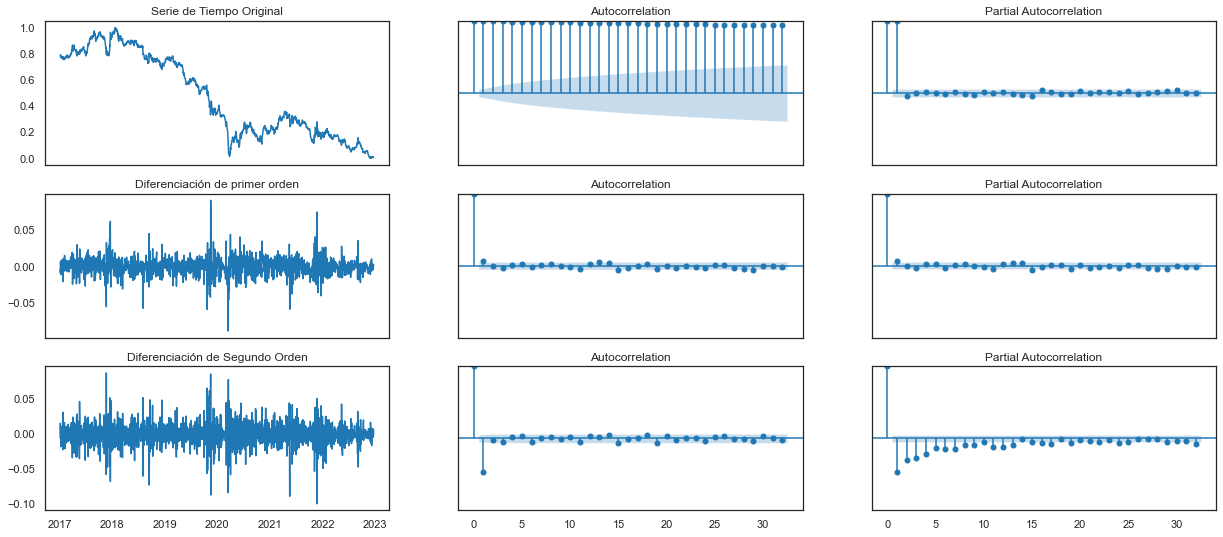

In [59]:
stationary(y_train)

Del analisis de estacionariedad del indice elaborado con las acciones del portafolio(FALABELLA y SONDA), podemos indicar:

(a) que el p-value en nuestra serie de tiempo original **no es estacionario** porque el **p-value** es 0.935, que es mayor que 0,05.
                                                             
            Serie de Tiempo Original
            ADF Statistic: -0.427358
            **p-value: 0.905430**
                                                             
(b) Después de la diferenciación de primer orden, los datos de la serie temporal **se vuelven estacionarios** ya que el **p-value** es menor que 0,05.
                                                             
            Diferenciación de primer orden
            ADF Statistic: -35.824647
            **p-value: 0.000000**

            Diferenciación de Segundo Orden
            ADF Statistic: -12.878742
            **p-value: 0.000000**

In [60]:
#
#Entrenar modelo con series de entrenamiento
#
# NOTA: se usa d=1, valor obtenido como resultado del analisis de estacionariedad en el paso anterior

#arima_param = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)
arima_param = auto_arima(y_train, start_p=3, d=1, start_q=3, max_p=5, max_q=5, trace=True, seasonal=False)
print(arima_param)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-8856.663, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8858.240, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8863.688, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8863.660, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8857.451, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8861.704, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8861.694, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8859.693, Time=0.84 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8863.271, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.738 seconds
 ARIMA(1,1,0)(0,0,0)[0] intercept


In [61]:
#
#arima_param.get_params {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 1, 0), 'out_of_sample_size': 0, 
#                         'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 
#                         'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}
#
print("arima_param.get_params:",arima_param )

algorithm = ARIMA(y_train, order=arima_param.get_params()["order"])
model = algorithm.fit()


arima_param.get_params:  ARIMA(1,1,0)(0,0,0)[0] intercept


In [62]:

# Pronosticos con serie de pruebas
forecast = model.get_forecast(steps=len(y_test))
prediction = forecast.predicted_mean #Retorna la serie de predicciones realizadas por el modelo.
ci = forecast.conf_int() #Retorna los intervalos de confianza inferior y superior


#
# Nota: los pronosticos llegaron sin fecha, a continuacion se agrega las fechas de la serie de pruebas como indices.
#
prediction.index= y_test.index
ci.index= y_test.index

#
# Crear DataFrames para las predicciones y los intervalos de confianza
#
forecast_df = pd.DataFrame({
    'Observado': y_test.Index,
    'Date': y_test.index,
    'Prediccion': prediction,
    'Intervalo_Conf_Inf': ci["lower Index"],
    'Intervalo_Conf_Sup': ci["upper Index"]
    })

forecast_df.set_index("Date", inplace=True)
forecast_df.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/ARIMA_forecast_equal-weighted.xlsx', index = True)
print("\n ***Arima y Pronosticos:*** \n",forecast_df)
# MSE y RMSE errores
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("La tasa de errores del pronostico con ARIMA son: \nMSE = %f \nRMSE = %f" %(mse, rmse))
 


 ***Arima y Pronosticos:*** 
             Observado  Prediccion  Intervalo_Conf_Inf  Intervalo_Conf_Sup
Date                                                                     
2022-12-21   0.014586    0.009112           -0.014697            0.032921
2022-12-22   0.019837    0.009114           -0.025800            0.044028
2022-12-23   0.025750    0.009114           -0.034217            0.052445
2022-12-26   0.026476    0.009114           -0.041250            0.059479
2022-12-27   0.023954    0.009114           -0.047416            0.065644
...               ...         ...                 ...                 ...
2023-08-09   0.157311    0.009114           -0.316474            0.334703
2023-08-10   0.152680    0.009114           -0.317485            0.335713
2023-08-11   0.150962    0.009114           -0.318492            0.336721
2023-08-14   0.148632    0.009114           -0.319496            0.337725
2023-08-16   0.143999    0.009114           -0.320498            0.338726

[165 r

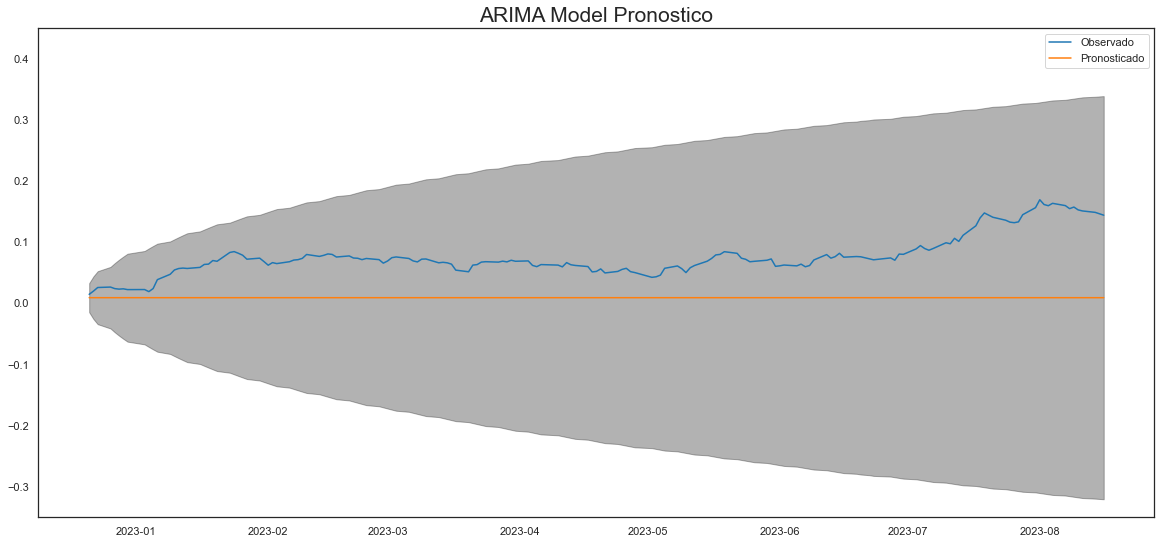

In [63]:
#
#Graficos de pronosticos vs observados
#
plt.figure(figsize=(20, 9))
plt.plot(forecast_df.index, forecast_df.Observado, label="Observado")
plt.plot(forecast_df.index, forecast_df.Prediccion, label="Pronosticado")
plt.fill_between(forecast_df.index, forecast_df.Intervalo_Conf_Inf,forecast_df.Intervalo_Conf_Sup, color="k", alpha=0.3)
plt.ylim([-0.35, 0.45])
plt.title("ARIMA Model Pronostico", fontsize=21)
plt.legend()
plt.show()

# Pronostico de la Serie de Tiempo usando SARIXMA e indice de portafolio de igual ponderación (equal-weighted)

## *Implementar SARIMAX Model*

La función del modelo SARIMAX es similar al modelo ARIMA pero agrega otros dos elementos: estacionalidad y factores externos.

La conclusión clave es que SARIMAX requiere no sólo los argumentos `p`, `d` y `q` que requiere ARIMA, sino que también requiere otro conjunto de argumentos `P`, `D` y `Q` para la estacionalidad. aspecto así como un argumento llamado "`m`". Es la periodicidad del ciclo estacional de los datos; es decir, es el número de períodos de cada temporada.

Al elegir un valor de m, se intenta obtener cuándo se ciclan los datos estacionales. Si los puntos de datos se separan mensualmente y el ciclo estacional es un año, establezca "m" en 12 meses. O si los puntos de datos se separan diariamente y el ciclo estacional es una semana, entonces haga que "s" sea igual a 7 (1 semana = 7 dias). 

El parámetros de estacionalidad `m` puede tomar los siguientes valores:

|Estacionalidad|m|
|-|-|
|Diaria|7|
|Semana|52|
|Mensual|12|
|Trimestral|4|
|Anual|1|


El modelo SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors) es una extensión del modelo ARIMA (Autoregressive Integrated Moving Average) que incorpora componentes de estacionalidad y también permite la inclusión de variables exógenas en la ecuación del modelo. El SARIMAX es una herramienta poderosa para analizar y pronosticar series de tiempo que exhiben patrones estacionales y que pueden ser influenciadas por variables externas.

Aquí hay una descripción de los componentes principales del modelo SARIMAX:

(1) Componentes ARIMA: Al igual que en el modelo ARIMA, el modelo SARIMAX incluye términos autoregresivos (AR), diferenciación (I) y términos de media móvil (MA). Estos componentes se utilizan para capturar las tendencias y patrones de la serie de tiempo.

(2) Componentes Estacionales: El "S" en SARIMAX se refiere a la componente estacional. El modelo SARIMAX tiene en cuenta patrones estacionales en la serie de tiempo y utiliza términos adicionales de ARIMA para modelar estos patrones estacionales. Esto es especialmente útil cuando la serie de tiempo muestra comportamientos repetitivos a lo largo del tiempo, como estacionalidad mensual o trimestral.

(3) Variables Exógenas: El "X" en SARIMAX se refiere a variables exógenas. Estas son variables independientes que no son parte de la serie de tiempo, pero que pueden influir en su comportamiento. El modelo SARIMAX permite la incorporación de estas variables para mejorar la precisión del pronóstico y para capturar relaciones causales o correlaciones.

En resumen, el modelo SARIMAX es una extensión flexible del modelo ARIMA que tiene en cuenta tanto la estacionalidad como las variables exógenas en la modelización de series de tiempo. Es útil cuando las series de tiempo muestran patrones estacionales y cuando hay factores externos que pueden afectar los datos. La inclusión de componentes estacionales y variables exógenas permite una mayor capacidad de ajuste a las características complejas de las series de tiempo del mundo real.

Ahora encontraremos los parámetros que se adaptan mejor al modelo. Para lo cual usaremos la herramienta `auto_arima` para ncontrar `p`, `q`, `P` y `Q`. 
No se necesita encontrar "d"  porque ya se realizo la prueba estacionaria en la sección anterior, lo que significa que "d" y "D" se pueden establecer en 1. 


In [64]:
#
#NOTA: La variable  exogenous debe referenciar a X_train (exogenous=X_train) y la variable "estacional"  debe estar en "True" (seasonal=True)
#   
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=2, start_Q=0, max_p=5, max_q=5, max_P=3, max_Q=3, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,2,0)[7]             : AIC=-6130.731, Time=0.14 sec
 ARIMA(1,1,0)(1,2,0)[7]             : AIC=-7063.403, Time=1.46 sec
 ARIMA(0,1,1)(0,2,1)[7]             : AIC=inf, Time=3.66 sec
 ARIMA(1,1,0)(0,2,0)[7]             : AIC=-6135.961, Time=0.20 sec
 ARIMA(1,1,0)(2,2,0)[7]             : AIC=-7467.456, Time=1.17 sec
 ARIMA(1,1,0)(3,2,0)[7]             : AIC=-7656.383, Time=2.51 sec
 ARIMA(1,1,0)(3,2,1)[7]             : AIC=inf, Time=11.85 sec
 ARIMA(1,1,0)(2,2,1)[7]             : AIC=inf, Time=7.75 sec
 ARIMA(0,1,0)(3,2,0)[7]             : AIC=-7649.647, Time=3.64 sec
 ARIMA(2,1,0)(3,2,0)[7]             : AIC=-7654.676, Time=2.88 sec
 ARIMA(1,1,1)(3,2,0)[7]             : AIC=-7653.904, Time=3.97 sec
 ARIMA(0,1,1)(3,2,0)[7]             : AIC=-7656.064, Time=2.39 sec
 ARIMA(2,1,1)(3,2,0)[7]             : AIC=-7652.724, Time=4.56 sec
 ARIMA(1,1,0)(3,2,0)[7] intercept   : AIC=-7654.383, Time=8.23 sec

Best model:  ARIMA(1,1,0)(3,2,0)[7]

El modelo SARIMAX muestra que el mejor modelo es  **ARIMA(1,1,0)(3,2,0)** entonces `p` es 1, `q` es 0, `P` es 3, `Q` is 0. Usaremos estos parámetros para entrenar nuestro modelo. 

En esta etapa, colocaremos el conjunto de datos de entrenamiento en `SARIMAX` y los parámetros que obtuvimos de `auto_arima` en `order` y los parámetros estacionales en `seasonal_order`.

In [65]:
print("sarimax_param.get_params():", sarimax_param)
algoritmo = SARIMAX(endog=y_train, exog=X_train, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"])
modelo = algoritmo.fit(disp=False)

sarimax_param.get_params():  ARIMA(1,1,0)(3,2,0)[7]          


In [66]:
# forecast the data
forecast = modelo.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test, dynamic=True)
predicciones = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("La tasa de error de predicciones SARIMAX es: \nMSE = %f \nRMSE = %f" %(mse, rmse))

La tasa de error de predicciones SARIMAX es: 
MSE = 0.074740 
RMSE = 0.005586


In [67]:

#
# Crear DataFrames para las predicciones y los intervalos de confianza
#
predicciones.index= y_test.index
ci.index= y_test.index

forecast_SARIMAX_df = pd.DataFrame({
    'Observado': y_test.Index,
    'Date': y_test.index,
    'Prediccion': predicciones,
    'Intervalo_Conf_Inf': ci["lower Index"],
    'Intervalo_Conf_Sup': ci["upper Index"]
    })

forecast_SARIMAX_df.set_index("Date", inplace=True)
forecast_SARIMAX_df.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/SARIXMA_forecast_equal-weighted.xlsx.xlsx', index = True)
print("\n Pronosticos con modelo SARIMAX con indice equal-weighted : \n",forecast_SARIMAX_df)


 Pronosticos con modelo SARIMAX con indice equal-weighted : 
             Observado  Prediccion  Intervalo_Conf_Inf  Intervalo_Conf_Sup
Date                                                                     
2022-12-21   0.014586    0.017621           -0.016880            0.052122
2022-12-22   0.019837    0.012498           -0.038331            0.063327
2022-12-23   0.025750    0.007396           -0.055804            0.070595
2022-12-26   0.026476    0.008298           -0.065229            0.081825
2022-12-27   0.023954    0.008505           -0.074068            0.091079
...               ...         ...                 ...                 ...
2023-08-09   0.157311    2.251451          -18.321415           22.824318
2023-08-10   0.152680    2.307869          -18.576552           23.192291
2023-08-11   0.150962    2.327551          -18.867386           23.522488
2023-08-14   0.148632    2.334768          -19.166487           23.836023
2023-08-16   0.143999    2.351754          -19.45

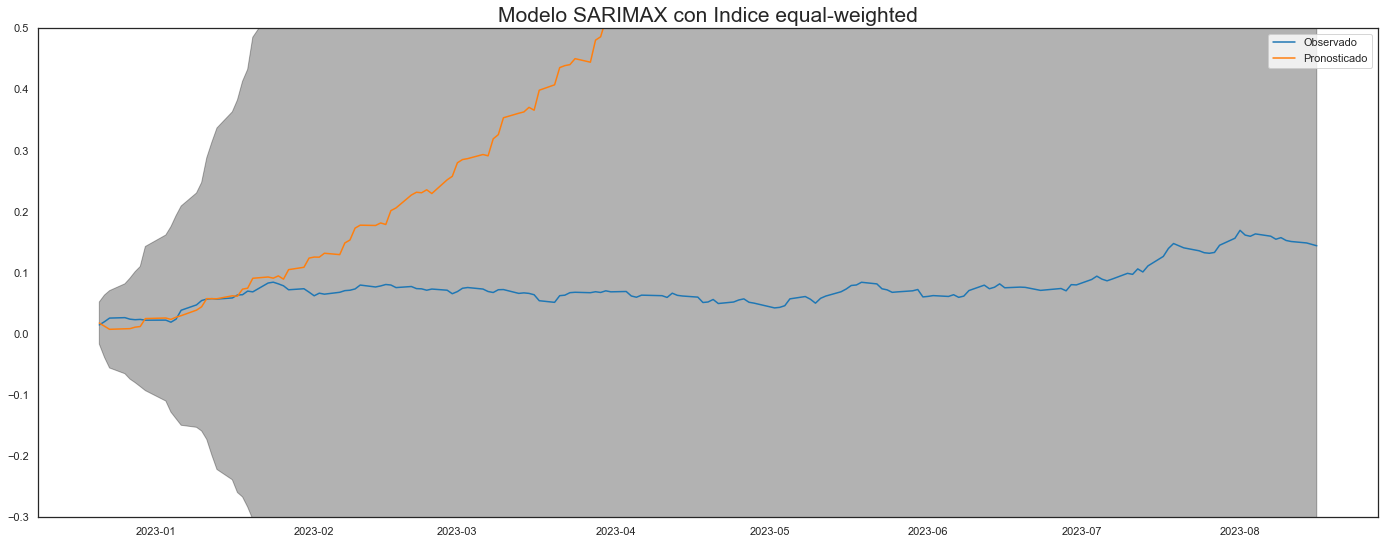

In [73]:
plt.figure(figsize=(24, 9))
plt.plot(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Observado, label="Observado")
plt.plot(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Prediccion, label="Pronosticado")
plt.fill_between(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Intervalo_Conf_Inf,forecast_SARIMAX_df.Intervalo_Conf_Sup, color="k", alpha=0.3)
plt.ylim([-0.3, 0.5])
plt.title("Modelo SARIMAX con Indice equal-weighted", fontsize=21)
plt.legend()
plt.show()


ANALISIS : Actualizar ----- >Como resultado del modelo SARIMAX, la tasa de error para predecir los valores del índice de 2 meses es relativamente baja pero un poco más alta que la del modelo ARIMA. Esto se debe a que no solo capturamos la estacionalidad de los datos, sino que también incluimos factores externos como el valor del índice de precios al consumidor o el precio del índice del mercado de valores para respaldar el modelo SARIMAX. Por lo tanto, cuando miramos el gráfico, podemos ver que la predicción es muy cercana a los movimientos reales del mercado y también captamos la aleatoriedad en el pronóstico, excepto el 11 de noviembre, cuando FTX repentinamente se declaró en quiebra.


# Pronostico de la Serie de Tiempo usando SARIXMA e indice de portafolio de capital ponderado (Capitalization-Weighted)

## Calculo del indice Capital Ponderado (Capitalization-Weighted)

Ahora usaremos como indice del portafolio el metodo **Capitalization-Weighted**,  en el cual el calculo considera el peso individual del capital de cada activo del portafolio de acciones, lo cual se representa con la siguiente formula: 

$${V} = {({P}_{1}{W}_{1}) + ({P}_{2}{W}_{2}) + ... +({P}_{n}{W}_{n})} $$

El peso **W** se asignará segun en el valor total en el portafolio del activo, usando la siguiente formula:
    
$${W = \frac{Preccio \space de \space Accion \times Cantidad}{Total \space Valor \space del \space Portafolio}}$$

 

In [81]:

my_assets=accionesChile

#w = cw_index(<fecha de la inversion>, [<Numero de unidades x activo>], [<Nemonicos>])

#
# En este ejemplo, se asume que el portafolio se constituye de 1 accion de SONDA y una de FALABELLA
#

w = capitalizationWeighted("2023-08-14", [1,1], ["FALABELLA","SONDA"])
#print("w:")
#print(w)

# calculate the index value
result = []
# calculate the index value por columna
for i in range(len(my_assets.columns)):
    asset = my_assets[my_assets.columns[i]]* w[my_assets.columns[i]].loc[0]
    result.append(asset)
print(result)
# Asigna el indice por cada fecha
capitalizationWeighted_index = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
capitalizationWeighted_index.set_axis([*capitalizationWeighted_index.columns[:-1], "Index"], axis=1, inplace=True)

#capitalizationWeighted_index.to_excel("./Forecasting_Cryptocurrency_Markets/capitalizationWeighted_index.xlsx")
#print("\--------------------------------------\n")
print("\n\ncapitalizationWeighted:\n")
print(capitalizationWeighted_index)


[Date
2017-01-03    4460.066253
2017-01-04    4462.747897
2017-01-05    4422.268292
2017-01-06    4451.517567
2017-01-09    4412.881514
                 ...     
2023-08-09    1951.912720
2023-08-10    1923.417644
2023-08-11    1918.389101
2023-08-14    1910.846287
2023-08-16    1888.301735
Name: FALABELLA, Length: 1648, dtype: float64, Date
2017-01-03    193.967609
2017-01-04    190.017013
2017-01-05    189.579865
2017-01-06    190.599883
2017-01-09    187.475041
                 ...    
2023-08-09     71.685441
2023-08-10     72.760523
2023-08-11     72.088595
2023-08-14     71.316288
2023-08-16     71.240190
Name: SONDA, Length: 1648, dtype: float64]


capitalizationWeighted:

                  Index
Date                   
2017-01-03  4655.033862
2017-01-04  4653.764910
2017-01-05  4612.848156
2017-01-06  4643.117450
2017-01-09  4601.356555
...                 ...
2023-08-09  2024.598162
2023-08-10  1997.178167
2023-08-11  1991.477696
2023-08-14  1983.162575
2023-08-16  1960.541925

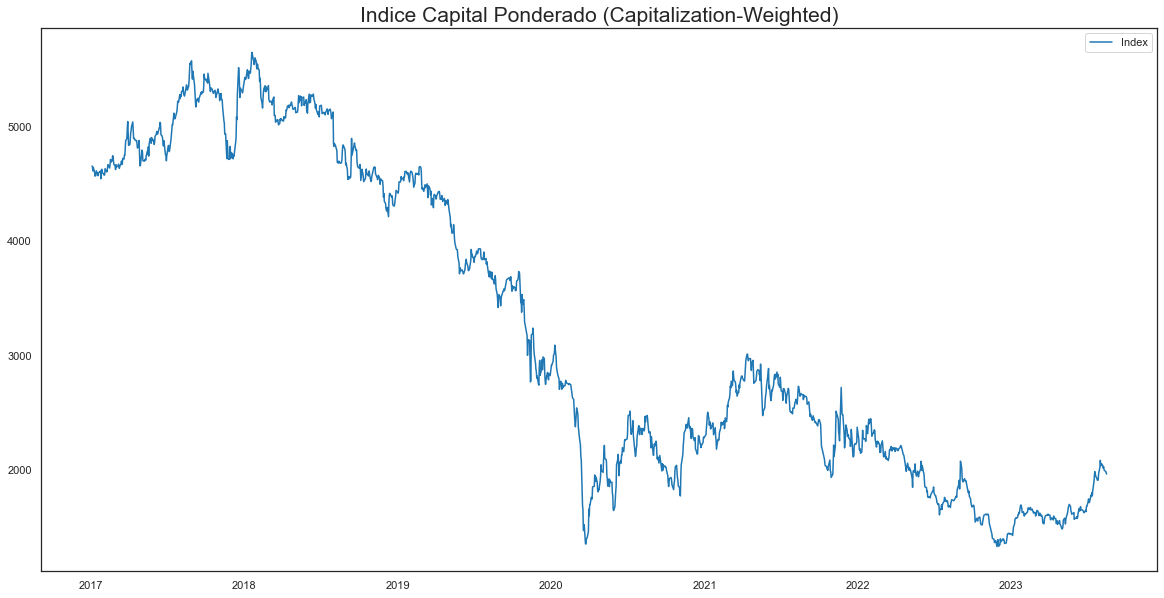

In [82]:
plt.figure(figsize=(20, 10))
for i  in range(len(capitalizationWeighted_index.columns)):
    plt.plot(capitalizationWeighted_index.index, capitalizationWeighted_index.iloc[:, i], label=capitalizationWeighted_index.columns[i])
plt.title("Indice Capital Ponderado (Capitalization-Weighted)", fontsize=21)
plt.legend()
plt.show()
 


In [83]:
dataSerieTiempo = pd.DataFrame(pd.date_range(start_date, end_date, freq="d"), columns=["Date"])
dataSerieTiempo = dataSerieTiempo.merge(factoresEconomicos, how="left", left_on='Date', right_on='Date')
dataSerieTiempo = dataSerieTiempo.merge(capitalizationWeighted_index.Index, how="left", left_on='Date', right_on='Date')

dataSerieTiempo.set_index("Date", inplace=True)
dataSerieTiempo = dataSerieTiempo.dropna()
#print(dataSerieTiempo.dtypes)
#print(dataSerieTiempo)
dataSerieTiempo.head(10)

,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB,Index
Date,,,,,,,,,,
2017-01-03,2.48,1145.90,10331.338847,30760.770745,85601.312371,49952.940290,26350.53,3.5,3.50,4655.033862
2017-01-04,2.51,1151.00,10175.895646,30387.480195,85695.133857,49901.742898,26351.38,3.5,3.50,4653.764910
2017-01-05,2.49,1164.25,10226.334464,30304.427807,85599.948202,50364.726872,26352.23,3.5,3.50,4612.848156
2017-01-06,2.55,1176.70,9872.782366,29970.630433,85439.401309,50382.196863,26353.08,3.5,3.49,4643.117450
2017-01-09,2.52,1175.85,10155.839117,29997.498068,85195.298814,50505.831450,26355.63,3.5,3.50,4601.356555
2017-01-10,2.53,1178.50,10075.714531,29628.015315,85200.584409,50374.274159,26353.93,3.5,3.49,4567.813813
2017-01-11,2.53,1189.50,9605.677170,30037.898116,85253.903462,49972.893468,26352.23,3.5,3.49,4572.834135
2017-01-12,2.60,1178.55,10082.191928,29875.128360,85086.066065,50127.976107,26350.52,3.5,3.50,4572.580652
2017-01-13,2.58,1205.05,10148.688813,29398.067357,87089.890892,50586.832845,26348.82,3.5,3.50,4614.103376


In [84]:
#
# Se escalan los valores a MinMaxScaler()  y eliminan correlaciones debiles ( entre -0.2 to 0.2)
#
# remove the weak corellation (% between -0.2 to 0.2)

dataSerieTiempo_normalizada , correlaciones = prepare_data(dataSerieTiempo)
dataSerieTiempo_normalizada.tail(5)

print("\nCorrelaciones de la Serie de tiempo normalizada:\n")
correlaciones.to_excel("./Forecasting_Cryptocurrency_Markets/capitalizationWeighted_index_normalizada_preparada_correlaciones.xlsx")

correlaciones.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)



Correlaciones de la Serie de tiempo normalizada:



,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB,Index
CobreUSD,1.00,0.92,0.94,0.97,-0.18,0.85,0.69,0.25,0.24,-0.84
OroUSD,0.92,1.00,0.91,0.95,0.08,0.95,0.83,0.40,0.38,-0.98
BaseMonetaria,0.94,0.91,1.00,0.99,-0.33,0.75,0.55,0.02,0.01,-0.81
M1,0.97,0.95,0.99,1.00,-0.22,0.83,0.65,0.15,0.13,-0.88
M2,-0.18,0.08,-0.33,-0.22,1.00,0.34,0.58,0.87,0.88,-0.27
M3,0.85,0.95,0.75,0.83,0.34,1.00,0.96,0.67,0.66,-0.98
UF,0.69,0.83,0.55,0.65,0.58,0.96,1.00,0.84,0.83,-0.91
TPM,0.25,0.40,0.02,0.15,0.87,0.67,0.84,1.00,1.00,-0.54
TIB,0.24,0.38,0.01,0.13,0.88,0.66,0.83,1.00,1.00,-0.53
Index,-0.84,-0.98,-0.81,-0.88,-0.27,-0.98,-0.91,-0.54,-0.53,1.00


In [85]:

dataSerieTiempo_normalizada.to_excel("./Forecasting_Cryptocurrency_Markets/capitalizationWeighted_index_normalizada.xlsx")
print(dataSerieTiempo_normalizada)

            CobreUSD    OroUSD  BaseMonetaria        M1        M2        M3  \
Date                                                                          
2017-01-03  0.125413  0.000000       0.035145  0.073422  0.152842  0.026827   
2017-01-04  0.135314  0.005598       0.030125  0.066835  0.154918  0.025847   
2017-01-05  0.128713  0.020143       0.031754  0.065369  0.152811  0.034712   
2017-01-06  0.148515  0.033810       0.020336  0.059479  0.149258  0.035046   
2017-01-09  0.138614  0.032877       0.029477  0.059953  0.143856  0.037413   
...              ...       ...            ...       ...       ...       ...   
2023-08-09  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-10  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-11  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-14  0.584158  0.893576       0.507170  0.517158  0.990226  0.850837   
2023-08-16  0.584158  0.893576       0.507170  0.517

In [94]:
X_train, X_test, y_train, y_test = time_series_split(dataSerieTiempo_normalizada, 0.95)
print("\ny_train:")
print(y_train)
print("\ny_test:")
print(y_test)
print("\nX_train:")
print(X_train)


y_train:
               Index
Date                
2017-01-03  0.769899
2017-01-04  0.769605
2017-01-05  0.760142
2017-01-06  0.767143
2017-01-09  0.757485
...              ...
2023-04-11  0.053762
2023-04-12  0.061868
2023-04-13  0.057964
2023-04-14  0.056938
2023-04-17  0.056848

[1565 rows x 1 columns]

y_test:
               Index
Date                
2023-04-18  0.046770
2023-04-19  0.047740
2023-04-20  0.052396
2023-04-21  0.044837
2023-04-24  0.047731
...              ...
2023-08-09  0.161563
2023-08-10  0.155222
2023-08-11  0.153903
2023-08-14  0.151980
2023-08-16  0.146749

[83 rows x 1 columns]

X_train:
            CobreUSD    OroUSD  BaseMonetaria        M1        M2        M3  \
Date                                                                          
2017-01-03  0.125413  0.000000       0.035145  0.073422  0.152842  0.026827   
2017-01-04  0.135314  0.005598       0.030125  0.066835  0.154918  0.025847   
2017-01-05  0.128713  0.020143       0.031754  0.065369  0.15

Serie de Tiempo Original
ADF Statistic: -0.660072
p-value: 0.856823

Diferenciación de primer orden
ADF Statistic: -37.006302
p-value: 0.000000

Diferenciación de Segundo Orden
ADF Statistic: -13.423039
p-value: 0.000000



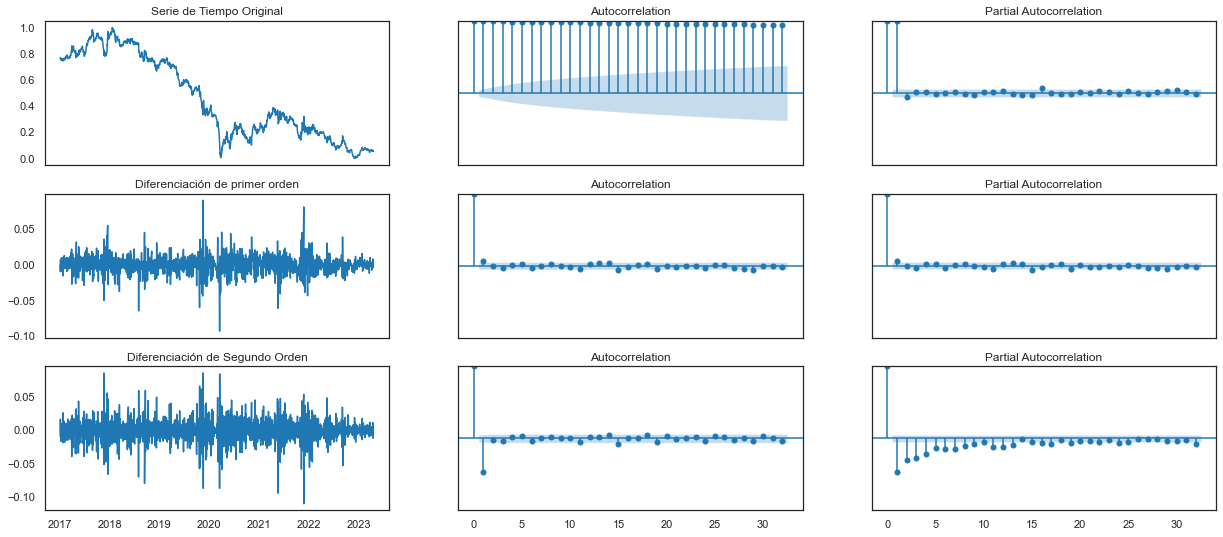

In [87]:
stationary(y_train)

In [88]:
# Encontrar los parametros  p, q, P, y  Q 

# d=1, diferenciacion de 1er orden

sarima_param = auto_arima(y_train, exogenous=X_train, m=7,start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)
print("sarima_param")
print(sarima_param)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-8130.106, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-8614.433, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-8135.517, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-8764.307, Time=0.68 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-8836.278, Time=0.95 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=5.30 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.64 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-8827.451, Time=0.70 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-8833.963, Time=1.08 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=-8834.073, Time=1.26 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=-8836.250, Time=2.45 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=-8832.685, Time=3.53 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=-8834.278, Time=5.04 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7] 

In [96]:
# train the models
algoritmo = SARIMAX(endog=y_train, exog=X_train[X_train.columns[[1, 8]]], order=sarima_param.get_params()["order"], seasonal_order=sarima_param.get_params()["seasonal_order"])
modelo = algoritmo.fit(disp=False)

# forecast the data
pronostico = modelo.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test[X_test.columns[[1, 3]]], dynamic=True)
prediccion = pronostico.predicted_mean
ci = pronostico.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediccion, squared=False)
print("La tasa de error de predicciones SARIMAX es: \nMSE = %f \nRMSE = %f" %(mse, rmse))

La tasa de error de predicciones SARIMAX es: 
MSE = 0.051829 
RMSE = 0.005586


In [97]:
#print(prediction)
prediccion.index= y_test.index
ci.index= y_test.index
#print("\ny_test\n")
#print(y_test)
#print("\prediction\n")
#print(prediction)
#print("\nci\n")
#print(ci)

#
# Crear DataFrames para las predicciones y los intervalos de confianza
#
forecast_SARIMAX_df = pd.DataFrame({
    'Observado': y_test.Index,
    'Date': y_test.index,
    'Prediccion': prediccion,
    'Intervalo_Conf_Inf': ci["lower Index"],
    'Intervalo_Conf_Sup': ci["upper Index"]
    })

forecast_SARIMAX_df.set_index("Date", inplace=True)
forecast_SARIMAX_df.to_excel('./PronosticoSerieTiempo-Stocks-Cryptos/forecast_SARIXMA_CapitalizationWeight_index.xlsx', index = True)
print("\n ***Arima y Pronosticos:*** \n",forecast_SARIMAX_df)


 ***Arima y Pronosticos:*** 
             Observado  Prediccion  Intervalo_Conf_Inf  Intervalo_Conf_Sup
Date                                                                     
2023-04-18   0.046770    0.082815            0.055191            0.110440
2023-04-19   0.047740    0.081994            0.041563            0.122425
2023-04-20   0.052396    0.084096            0.033957            0.134235
2023-04-21   0.044837    0.085707            0.027451            0.143962
2023-04-24   0.047731    0.083765            0.018393            0.149138
...               ...         ...                 ...                 ...
2023-08-09   0.161563    0.055586           -0.803490            0.914661
2023-08-10   0.155222    0.057010           -0.816875            0.930896
2023-08-11   0.153903    0.059378           -0.829071            0.947828
2023-08-14   0.151980    0.058510           -0.844269            0.961289
2023-08-16   0.146749    0.054964           -0.861920            0.971848

[83 ro

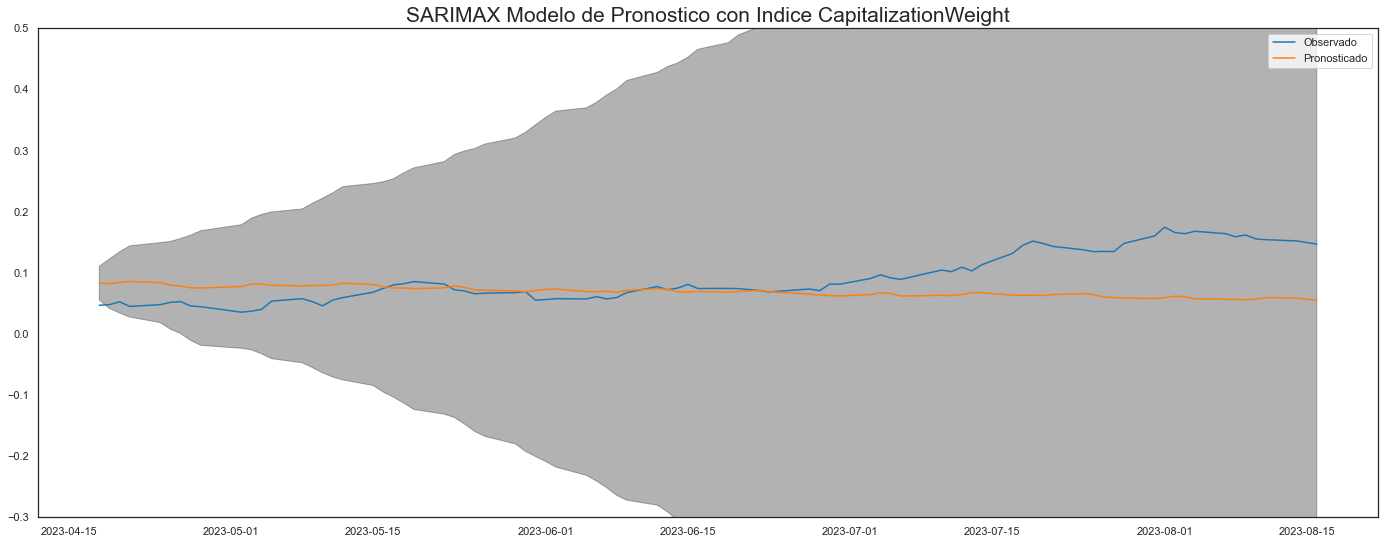

In [98]:
# show the forecasting SARIMAX in plot
plt.figure(figsize=(24, 9))
plt.plot(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Observado, label="Observado")
plt.plot(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Prediccion, label="Pronosticado")
plt.fill_between(forecast_SARIMAX_df.index, forecast_SARIMAX_df.Intervalo_Conf_Inf,forecast_SARIMAX_df.Intervalo_Conf_Sup, color="k", alpha=0.3)
plt.ylim([-0.3, 0.5])
plt.title("SARIMAX Modelo de Pronostico con Indice CapitalizationWeight", fontsize=21)
plt.legend()
plt.show()

# ANEXOS: 

### Como Determinar el parametro "d"

**Estacionario** es un factor que describe la previsibilidad de los datos de series de tiempo. La **estacionaria estricta** **describe toda la distribución de probabilidad como invariante en cambio de tiempo, y la **estacionari débil** informa que la media y la covarianza son invariantes en cambio de tiempo, lo que significa que el momento t del valor **depende en gran medida de su historia**. 

 
Usaremos una de las pruebas estadísticas de tipo simple (prueba de raíz unitaria) llamada **prueba de Dickey-Fuller aumentada**, para verificar si la serie de tiempo es estacionaria o no estacionaria. Entonces, en la prueba de hipótesis, cuando:

p-value > **0.05** : no se puede rechazar la hipótesis nula (${H_0}$, los datos de la serie temporal no son estacionarios.

p-value <= **0.05** : Rechazar la hipótesis nula (${H_0}$), los datos de la serie temporal son estacionarios.

Usaremos la función estacionaria ( **stationary(y_train)**) para verificar si los datos de la serie temporal son estacionarios.



Serie de Tiempo Original
ADF Statistic: -0.660072
p-value: 0.856823

Diferenciación de primer orden
ADF Statistic: -37.006302
p-value: 0.000000

Diferenciación de Segundo Orden
ADF Statistic: -13.423039
p-value: 0.000000



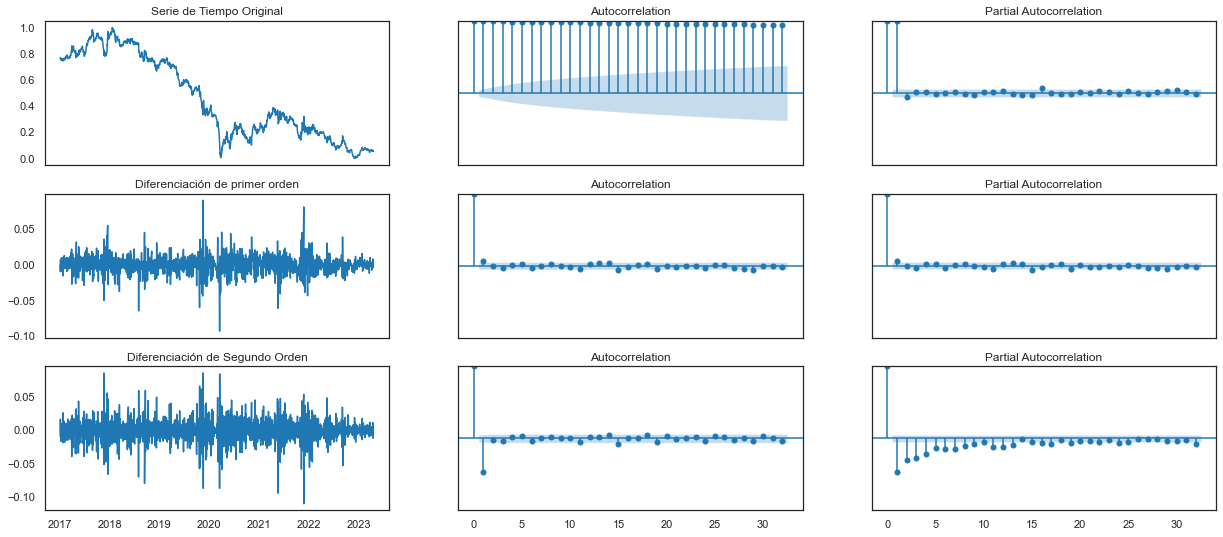

In [99]:
stationary(y_train)


Como resultado, podemos observar que: 
(a) el valor p en nuestra serie de tiempo original **no es estacionario** porque el valor p es 0,62, 
que es mayor que 0,05.
                                                             
           Serie de Tiempo Original
            ADF Statistic: -1.648672
            p-value: **0.457733**
                                                             
(b) Después de la diferenciación de primer orden, los datos de la serie temporal **se vuelven estacionarios** ya que el valor p es menor que 0,05.
                                                             
            Diferenciación de primer orden
            ADF Statistic: -32.806420
            p-value: **0.000000**

            Diferenciación de Segundo Orden
            ADF Statistic: -12.123320
            p-value: **0.000000**

## *Como encontrar las correlaciones entre variables?*

Para verificar la correlación entre nuestras variables objetivo y las variables predictoras. Usaremos el coeficiente de correlación de Pearson para analizar la correlación y, según la siguiente figura, eliminaremos las variables de correlación débiles (coeficiente de correlación entre -0,2 y 0,2).


Entre

- [0.8  a 1.0]/[-0.8  a -1.0] , es una muy fuerte correlacion positiva/negativa
- [0.6  a 0.8]/[-0.6  a -0.8] , es una fuerte correlacion positiva/negativa
- [0.4  a 0.6]/[-0.4  a -0.6] , es una moderada correlacion positiva/negativa
- [0.2  a 0.4]/[-0.2  a -0.4] , es una debil correlacion positiva/negativa
- [0.0  a 0.2]/[0.0  a -0.2] , es una muy debil correlacion positiva/negativa
- [0.0]        , No existe correlacion


In [93]:
correlaciones.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,CobreUSD,OroUSD,BaseMonetaria,M1,M2,M3,UF,TPM,TIB,Index
CobreUSD,1.00,0.92,0.94,0.97,-0.18,0.85,0.69,0.25,0.24,-0.84
OroUSD,0.92,1.00,0.91,0.95,0.08,0.95,0.83,0.40,0.38,-0.98
BaseMonetaria,0.94,0.91,1.00,0.99,-0.33,0.75,0.55,0.02,0.01,-0.81
M1,0.97,0.95,0.99,1.00,-0.22,0.83,0.65,0.15,0.13,-0.88
M2,-0.18,0.08,-0.33,-0.22,1.00,0.34,0.58,0.87,0.88,-0.27
M3,0.85,0.95,0.75,0.83,0.34,1.00,0.96,0.67,0.66,-0.98
UF,0.69,0.83,0.55,0.65,0.58,0.96,1.00,0.84,0.83,-0.91
TPM,0.25,0.40,0.02,0.15,0.87,0.67,0.84,1.00,1.00,-0.54
TIB,0.24,0.38,0.01,0.13,0.88,0.66,0.83,1.00,1.00,-0.53
Index,-0.84,-0.98,-0.81,-0.88,-0.27,-0.98,-0.91,-0.54,-0.53,1.00
